In [1]:
# Fix NumPy version issue
#%pip install numpy==1.24.3

In [2]:
#%pip install textblob

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional, Union, Any

In [4]:
# For processing text
from bs4 import BeautifulSoup
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
import spacy
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Seed
import numpy as np
np.random.seed(42)

### 1. Data Understanding & Preparation

1. I will load and explore the dataset structure.
2. Then I will examine the articles content, sources, publication dates, and metadata.
3. I will clean the data by removing web crawl artifacts (HTML tags, etc).
4. I will filter out irrelevant articles that don't focus on AI's impact on industries.

In [6]:
import pandas as pd
df = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (200083, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200083 entries, 0 to 200082
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       200083 non-null  object
 1   date      200083 non-null  object
 2   language  200083 non-null  object
 3   title     200083 non-null  object
 4   text      200083 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


In [7]:
df.head()

,url,date,language,title,text
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,en,Infogain AI Business Solutions Now Available i...,\n\nInfogain AI Business Solutions Now Availab...
1,https://allafrica.com/stories/202504250184.html,2025-04-25,en,Africa: AI Policies in Africa - Lessons From G...,\nAfrica: AI Policies in Africa - Lessons From...
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,en,Yang Lan interviews academics on AI developmen...,\nYang Lan interviews academics on AI developm...
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,en,Commerce Nominee Promises Increased Domestic A...,\nCommerce Nominee Promises Increased Domestic...
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,en,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry:...


### Data Cleaning and Preprocessing

### Named Entity Recognition

### Industry and Job Detection

### Technology Identification

### Sentiment Analysis

### Topic Modeling

In [8]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional, Union, Any

# For processing text
from bs4 import BeautifulSoup
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
import spacy
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure NLTK resources are available
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

class AINewsAnalyzer:
    """Main class for analyzing AI-related news articles"""

    def __init__(self, data_path: str, cache_dir: str = "cache", spacy_model: str = "en_core_web_md"):
        """Initialize the analyzer with data path and cache directory"""
        self.data_path = data_path
        self.cache_dir = cache_dir

        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)

        # SpaCy
        print("Loading SpaCy model...")
        try:
            self.nlp = spacy.load(spacy_model)
        except OSError:
            print(f"SpaCy model {spacy_model} not found. Please run: python -m spacy download {spacy_model}")
            print("Falling back to smaller model...")
            try:
                self.nlp = spacy.load("en_core_web_sm")
            except OSError:
                print("No SpaCy models found. Please install one with: python -m spacy download en_core_web_sm")
                self.nlp = None

        # Create comprehensive dictionaries
        self._create_dictionaries()

        # Data
        self.df = self._load_data()
        print(f"Loaded dataset with {len(self.df)} articles")

    def _load_data(self) -> pd.DataFrame:
        """Load the dataset from parquet file"""
        return pd.read_parquet(self.data_path, engine='pyarrow')

    def _get_cache_path(self, filename: str) -> str:
        """Get full path for a cache file"""
        return os.path.join(self.cache_dir, filename)

    def _save_to_cache(self, obj: Any, filename: str) -> None:
        """Save object to cache"""
        with open(self._get_cache_path(filename), 'wb') as f:
            pickle.dump(obj, f)

    def _load_from_cache(self, filename: str) -> Any:
        """Load object from cache if it exists"""
        cache_path = self._get_cache_path(filename)
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                return pickle.load(f)
        return None

    def _create_dictionaries(self):
        """Create comprehensive dictionaries for analysis without labeled data"""

        # Create basic sentiment dictionaries
        self._create_sentiment_dictionaries()

        # Create industry and job dictionaries
        self._create_industry_dictionaries()
        self._create_job_dictionaries()

        # Create technology dictionaries
        self._create_technology_dictionaries()

        # Create impact dictionaries (positive and negative impacts)
        self._create_impact_dictionaries()

    def _expand_dictionary_with_synonyms(self, base_dict, num_synonyms=3):
        """Expand a dictionary using synonyms to increase coverage"""
        expanded_dict = base_dict.copy()

        for term, value in base_dict.items():
            # Skip multi-word terms for synonym expansion
            if ' ' in term:
                continue

            # Get synonyms from WordNet
            synonyms = []
            for syn in wordnet.synsets(term):
                for lemma in syn.lemmas():
                    if lemma.name() != term and lemma.name() not in expanded_dict:
                        synonyms.append(lemma.name())

            # Add top N synonyms with same value as original term
            for synonym in synonyms[:num_synonyms]:
                if synonym not in expanded_dict:
                    expanded_dict[synonym] = value

        return expanded_dict

    def _create_sentiment_dictionaries(self) -> None:
        """Create dictionaries for domain-specific sentiment analysis"""
        # Positive terms related to AI in workplace context
        self.positive_terms = {
            # Opportunity and Growth
            'opportunity': 1.0, 'enhance': 0.8, 'improve': 0.8, 'augment': 0.7,
            'growth': 0.7, 'advancement': 0.8, 'upskill': 0.9, 'progress': 0.7,
            'potential': 0.5, 'revolutionize': 0.8, 'transform': 0.7,

            # Productivity and Efficiency
            'efficiency': 0.8, 'productivity': 0.8, 'streamline': 0.7,
            'optimize': 0.7, 'accelerate': 0.6, 'automate': 0.6,

            # Collaboration and Assistance
            'assist': 0.6, 'empower': 0.9, 'collaborate': 0.7, 'partnership': 0.6,
            'complement': 0.7, 'teamwork': 0.7, 'support': 0.6, 'aid': 0.6,

            # Solution and Benefit
            'solution': 0.6, 'benefit': 0.8, 'advantage': 0.7, 'value': 0.6,
            'solve': 0.7, 'facilitate': 0.6, 'enable': 0.7,

            # Innovation and Creation
            'innovation': 0.9, 'create': 0.6, 'invent': 0.7, 'develop': 0.6,
            'pioneer': 0.8, 'breakthrough': 0.9, 'novel': 0.7
        }

        # Negative terms related to AI in workplace context
        self.negative_terms = {
            # Job Loss and Replacement
            'replace': -0.8, 'eliminate': -0.9, 'displace': -0.8, 'substitute': -0.7,
            'job loss': -0.9, 'unemployment': -0.9, 'layoff': -0.9, 'redundant': -0.8,
            'downsizing': -0.8, 'obsolete': -0.8, 'outdated': -0.7,

            # Risk and Threat
            'threaten': -0.7, 'risk': -0.6, 'danger': -0.7, 'concern': -0.5,
            'worry': -0.6, 'fear': -0.7, 'threat': -0.8, 'harmful': -0.8,

            # Problems and Challenges
            'controversy': -0.6, 'problem': -0.6, 'challenge': -0.4, 'difficulty': -0.5,
            'obstacle': -0.5, 'hurdle': -0.4, 'barrier': -0.5,

            # Social Issues
            'inequality': -0.7, 'bias': -0.7, 'discrimination': -0.8, 'unfair': -0.7,
            'disparity': -0.7, 'divide': -0.6, 'exclusion': -0.7,

            # Control and Privacy
            'surveillance': -0.8, 'monitor': -0.6, 'control': -0.6, 'invasion': -0.7,
            'privacy': -0.7, 'intrusive': -0.7, 'oversight': -0.5
        }

        # Optionally expand dictionaries with synonyms
        try:
            self.positive_terms = self._expand_dictionary_with_synonyms(self.positive_terms)
            self.negative_terms = self._expand_dictionary_with_synonyms(self.negative_terms)
        except:
            print("Warning: Could not expand dictionaries with synonyms. Make sure NLTK's WordNet is installed.")

    def _create_industry_dictionaries(self):
        """Create comprehensive industry dictionaries using domain knowledge"""

        self.industry_terms = {
            'healthcare': [
                # Medical professionals
                'doctor', 'physician', 'nurse', 'surgeon', 'pharmacist',
                # Settings
                'hospital', 'clinic', 'medical center', 'emergency room', 'icu',
                # Concepts
                'patient', 'care', 'treatment', 'diagnosis', 'therapy', 'medicine',
                # Specialties
                'radiology', 'oncology', 'cardiology', 'pediatrics', 'psychiatry',
                # Technologies
                'telemedicine', 'ehr', 'mri', 'ct scan', 'x-ray', 'medical imaging',
                # Healthcare specific
                'healthcare', 'health care', 'medical', 'pharma', 'pharmaceutical',
                'biotech', 'biotechnology', 'drug', 'clinical'
            ],

            'finance': [
                # Banking and institutions
                'bank', 'banking', 'credit union', 'financial institution',
                # Investment
                'investment', 'investor', 'stock', 'bond', 'portfolio', 'hedge fund',
                'mutual fund', 'asset management', 'venture capital', 'private equity',
                # Insurance
                'insurance', 'insurer', 'policy', 'premium', 'underwriting', 'actuary',
                # Lending
                'loan', 'credit', 'mortgage', 'lending', 'borrowing', 'debt',
                # Trading
                'trading', 'trader', 'exchange', 'market', 'securities', 'derivatives',
                # Fintech
                'fintech', 'payment', 'digital banking', 'blockchain', 'cryptocurrency',
                # General
                'finance', 'financial', 'monetary', 'fiscal', 'economic', 'economy'
            ],

            'manufacturing': [
                # Production processes
                'production', 'manufacturing', 'assembly', 'fabrication', 'processing',
                # Facilities
                'factory', 'plant', 'workshop', 'industrial', 'facility', 'warehouse',
                # Equipment
                'machinery', 'equipment', 'tooling', 'robotics', 'automation', 'cnc',
                # Industries
                'automotive', 'aerospace', 'electronics', 'textiles', 'chemical',
                'pharmaceutical', 'food processing', 'beverage', 'consumer goods',
                # Concepts
                'supply chain', 'inventory', 'quality control', 'lean', 'six sigma',
                'just-in-time', 'kanban', 'logistics', 'throughput', 'yield',
                # Advanced manufacturing
                'industry 4.0', 'smart factory', 'iot', 'digital twin', 'predictive maintenance'
            ],

            'retail': [
                # Channels
                'store', 'shop', 'outlet', 'boutique', 'mall', 'marketplace', 'supermarket',
                'e-commerce', 'ecommerce', 'online store', 'website', 'platform',
                # Roles
                'retailer', 'merchant', 'seller', 'vendor', 'brand', 'customer', 'consumer',
                'shopper', 'buyer', 'client',
                # Operations
                'inventory', 'stock', 'supply chain', 'logistics', 'fulfillment', 'warehouse',
                'distribution', 'shipping', 'delivery',
                # Marketing
                'sale', 'discount', 'promotion', 'marketing', 'advertising', 'merchandising',
                # Technologies
                'pos', 'point of sale', 'checkout', 'payment', 'omnichannel', 'multichannel',
                # General
                'retail', 'commerce', 'shopping', 'purchase', 'transaction'
            ],

            'education': [
                # Institutions
                'school', 'university', 'college', 'academy', 'institute', 'campus',
                # People
                'student', 'teacher', 'professor', 'instructor', 'faculty', 'educator',
                'academic', 'pupil', 'learner', 'scholar',
                # Learning
                'education', 'learning', 'teaching', 'training', 'instruction', 'curriculum',
                'course', 'class', 'lecture', 'seminar', 'workshop', 'lesson',
                # Levels
                'elementary', 'primary', 'secondary', 'high school', 'higher education',
                'undergraduate', 'graduate', 'postgraduate', 'doctoral',
                # EdTech
                'edtech', 'e-learning', 'online learning', 'mooc', 'lms', 'educational technology',
                'digital learning', 'distance learning', 'remote learning', 'virtual classroom'
            ],

            'technology': [
                # Computing
                'software', 'hardware', 'computer', 'server', 'database', 'cloud', 'computing',
                'programming', 'code', 'algorithm', 'development', 'engineering',
                # Internet
                'internet', 'web', 'website', 'app', 'application', 'platform', 'online',
                'digital', 'network', 'connectivity',
                # Companies
                'tech company', 'startup', 'tech giant', 'technology provider', 'vendor',
                # Services
                'saas', 'paas', 'iaas', 'service', 'solution', 'product', 'offering',
                # Innovation
                'innovation', 'research', 'development', 'r&d', 'emerging tech',
                # General
                'tech', 'technology', 'it', 'information technology', 'digital transformation'
            ],

            'agriculture': [
                # Farming
                'farm', 'farming', 'agriculture', 'agricultural', 'crop', 'livestock',
                'planting', 'harvesting', 'cultivation', 'irrigation',
                # Products
                'crop', 'grain', 'produce', 'fruit', 'vegetable', 'livestock', 'cattle',
                'dairy', 'poultry', 'meat',
                # Farming types
                'organic', 'conventional', 'sustainable', 'regenerative', 'precision agriculture',
                # Equipment
                'tractor', 'combine', 'machinery', 'equipment', 'irrigation', 'greenhouse',
                # Concepts
                'yield', 'soil', 'fertilizer', 'pesticide', 'seed', 'breeding', 'genetics',
                # AgTech
                'agtech', 'agricultural technology', 'farm management', 'smart farming',
                'vertical farming', 'hydroponics', 'aquaponics', 'food production'
            ],

            'transportation': [
                # Modes
                'transport', 'transportation', 'logistics', 'shipping', 'freight',
                'automotive', 'trucking', 'rail', 'railway', 'aviation', 'maritime',
                'shipping', 'delivery',
                # Vehicles
                'car', 'truck', 'van', 'bus', 'train', 'aircraft', 'plane', 'ship', 'vessel',
                'vehicle', 'fleet',
                # Infrastructure
                'road', 'highway', 'railway', 'airport', 'port', 'terminal', 'station',
                'warehouse', 'distribution center',
                # Operations
                'route', 'schedule', 'dispatch', 'delivery', 'tracking', 'fleet management',
                # Advanced tech
                'autonomous vehicle', 'self-driving', 'electric vehicle', 'ev', 'mobility',
                'ride-sharing', 'ride-hailing', 'last mile', 'drone delivery'
            ],

            'media': [
                # Types
                'media', 'news', 'entertainment', 'publishing', 'broadcast', 'film',
                'television', 'radio', 'newspaper', 'magazine', 'digital media',
                'social media', 'streaming',
                # Content
                'content', 'article', 'story', 'program', 'show', 'series', 'movie',
                'video', 'audio', 'podcast',
                # Roles
                'journalist', 'reporter', 'editor', 'producer', 'director', 'creator',
                'writer', 'author',
                # Advertising
                'advertising', 'marketing', 'campaign', 'ad', 'commercial', 'promotion',
                # Concepts
                'audience', 'viewer', 'reader', 'subscriber', 'engagement', 'reach',
                'distribution', 'publication', 'broadcast', 'release'
            ],

            'legal': [
                # Professions
                'legal', 'lawyer', 'attorney', 'counsel', 'judge', 'paralegal',
                'solicitor', 'barrister', 'notary',
                # Practice areas
                'litigation', 'corporate', 'criminal', 'civil', 'family', 'tax',
                'intellectual property', 'patent', 'trademark', 'copyright',
                'environmental', 'labor', 'employment', 'immigration',
                # Activities
                'law', 'regulation', 'compliance', 'contract', 'agreement', 'case',
                'lawsuit', 'claim', 'dispute', 'trial', 'hearing', 'deposition',
                'negotiation', 'arbitration', 'mediation',
                # Documents
                'brief', 'motion', 'filing', 'document', 'contract', 'agreement',
                'testimony', 'evidence', 'ruling', 'decision', 'verdict',
                # Institutions
                'court', 'firm', 'law firm', 'legal services', 'practice', 'chamber'
            ]
        }

        # Add weights to industry terms to reflect their importance or specificity
        self.industry_term_weights = {
            'healthcare': {'hospital': 5, 'doctor': 4, 'patient': 3, 'medical': 2, 'healthcare': 5},
            'finance': {'bank': 5, 'investment': 4, 'financial': 3, 'loan': 2, 'finance': 5},
            'manufacturing': {'factory': 5, 'manufacturing': 5, 'production': 4, 'assembly': 3},
            'retail': {'store': 4, 'retail': 5, 'e-commerce': 5, 'consumer': 3},
            'education': {'school': 5, 'university': 5, 'student': 4, 'education': 5},
            'technology': {'software': 4, 'tech': 5, 'technology': 5, 'digital': 3},
            'agriculture': {'farm': 5, 'agriculture': 5, 'crop': 4, 'farming': 5},
            'transportation': {'logistics': 5, 'shipping': 4, 'transport': 5, 'delivery': 3},
            'media': {'media': 5, 'news': 4, 'content': 3, 'publishing': 4},
            'legal': {'lawyer': 5, 'legal': 5, 'law': 4, 'attorney': 5}
        }

    def _create_job_dictionaries(self):
        """Create dictionaries related to job roles and occupations"""

        self.job_terms = {
            'management': [
                # Executives
                'ceo', 'chief executive officer', 'cfo', 'chief financial officer',
                'cio', 'chief information officer', 'cto', 'chief technology officer',
                'coo', 'chief operating officer', 'president', 'vice president',
                'executive', 'director',
                # Management levels
                'manager', 'supervisor', 'team lead', 'team leader', 'head of',
                'chief', 'senior manager', 'junior manager', 'middle manager',
                # Functions
                'project manager', 'product manager', 'operations manager',
                'account manager', 'sales manager', 'marketing manager',
                # General
                'management', 'leadership', 'administration', 'executive', 'supervise'
            ],

            'engineering': [
                # Software
                'software engineer', 'developer', 'programmer', 'coder', 'web developer',
                'frontend developer', 'backend developer', 'full stack developer',
                'mobile developer', 'game developer', 'devops',
                # Data
                'data scientist', 'data engineer', 'data analyst', 'machine learning engineer',
                'ai engineer', 'artificial intelligence engineer', 'ml engineer',
                # Hardware/Systems
                'hardware engineer', 'systems engineer', 'network engineer',
                'cloud engineer', 'reliability engineer', 'security engineer',
                # Traditional engineering
                'mechanical engineer', 'electrical engineer', 'civil engineer',
                'chemical engineer', 'industrial engineer', 'aerospace engineer',
                # General
                'engineer', 'engineering', 'technical', 'architect', 'technician'
            ],

            'healthcare_worker': [
                # Physicians
                'doctor', 'physician', 'surgeon', 'specialist', 'pediatrician',
                'cardiologist', 'oncologist', 'neurologist', 'psychiatrist',
                'anesthesiologist', 'radiologist',
                # Nursing
                'nurse', 'registered nurse', 'rn', 'nurse practitioner', 'lpn',
                'nursing assistant', 'cna',
                # Allied health
                'pharmacist', 'therapist', 'physical therapist', 'occupational therapist',
                'speech therapist', 'respiratory therapist', 'nutritionist', 'dietitian',
                'audiologist', 'optometrist',
                # Technical
                'technician', 'lab technician', 'radiology technician', 'phlebotomist',
                'medical assistant', 'paramedic', 'emt',
                # General
                'healthcare worker', 'medical professional', 'clinician', 'caregiver'
            ],

            'finance_professional': [
                # Banking
                'banker', 'teller', 'loan officer', 'branch manager', 'credit analyst',
                # Investment
                'investment banker', 'financial advisor', 'financial planner',
                'portfolio manager', 'fund manager', 'trader', 'broker', 'analyst',
                'equity analyst', 'research analyst', 'investment analyst',
                # Accounting
                'accountant', 'cpa', 'certified public accountant', 'auditor',
                'tax accountant', 'bookkeeper', 'controller',
                # Insurance
                'actuary', 'underwriter', 'claims adjuster', 'insurance agent',
                # General
                'finance professional', 'financial', 'economist', 'treasury'
            ],

            'customer_service': [
                # Roles
                'customer service representative', 'csr', 'customer support',
                'help desk', 'call center agent', 'call center representative',
                'customer care', 'customer success', 'client services',
                'technical support', 'support specialist',
                # Related
                'representative', 'agent', 'associate', 'advisor', 'consultant',
                # General
                'customer service', 'support', 'customer support', 'service desk'
            ],

            'manufacturing_worker': [
                # Production
                'factory worker', 'production worker', 'assembly worker', 'assembler',
                'production line worker', 'machine operator', 'equipment operator',
                # Skilled trades
                'machinist', 'welder', 'fabricator', 'electrician', 'maintenance technician',
                'millwright', 'carpenter', 'plumber', 'mechanic',
                # Quality and inspection
                'quality control', 'quality assurance', 'inspector', 'tester',
                # Supervision
                'foreman', 'crew leader', 'shift supervisor', 'production supervisor',
                # General
                'manufacturing worker', 'industrial worker', 'plant worker', 'operator'
            ],

            'clerical': [
                # Administrative
                'administrative assistant', 'admin assistant', 'admin', 'office assistant',
                'executive assistant', 'secretary', 'receptionist', 'office manager',
                # Specialized
                'clerk', 'data entry', 'file clerk', 'records clerk', 'billing clerk',
                'accounting clerk', 'payroll clerk', 'medical records', 'legal secretary',
                # Coordination
                'coordinator', 'administrative coordinator', 'office coordinator',
                'project coordinator', 'scheduling coordinator',
                # General
                'clerical', 'administrative', 'admin', 'office staff', 'back office'
            ],

            'creative': [
                # Design
                'designer', 'graphic designer', 'web designer', 'ui designer',
                'ux designer', 'product designer', 'industrial designer',
                'fashion designer', 'interior designer',
                # Content creation
                'writer', 'copywriter', 'content writer', 'author', 'editor',
                'content creator', 'blogger', 'journalist',
                # Media production
                'producer', 'director', 'photographer', 'videographer', 'filmmaker',
                'animator', 'illustrator',
                # Marketing
                'marketer', 'marketing specialist', 'brand manager', 'social media manager',
                'digital marketer', 'content marketer',
                # General
                'creative', 'artist', 'creator', 'creative professional'
            ],

            'education': [
                # School
                'teacher', 'elementary teacher', 'high school teacher', 'special education teacher',
                'school counselor', 'principal', 'superintendent', 'administrator',
                # Higher ed
                'professor', 'assistant professor', 'associate professor', 'adjunct professor',
                'lecturer', 'instructor', 'faculty', 'dean', 'academic',
                # Other teaching
                'tutor', 'coach', 'trainer', 'educator', 'teaching assistant', 'instructor',
                # General
                'education professional', 'educator', 'academic staff', 'teaching'
            ],

            'legal': [
                # Attorneys
                'lawyer', 'attorney', 'counsel', 'associate', 'partner', 'litigator',
                'prosecutor', 'public defender', 'defense attorney',
                # Judiciary
                'judge', 'magistrate', 'justice', 'clerk of court', 'law clerk',
                # Support
                'paralegal', 'legal assistant', 'legal secretary', 'legal researcher',
                # Compliance
                'compliance officer', 'legal officer', 'regulatory affairs',
                # General
                'legal professional', 'legal counsel', 'legal staff'
            ]
        }

        # Additionally, create a flattened dictionary for easier lookups
        self.job_term_to_category = {}
        for category, terms in self.job_terms.items():
            for term in terms:
                self.job_term_to_category[term] = category

    def _create_technology_dictionaries(self):
        """Create dictionaries for AI and technology terms"""

        self.technology_terms = {
            'machine_learning': [
                # Core ML
                'machine learning', 'ml', 'artificial intelligence', 'ai', 'algorithm',
                'supervised learning', 'unsupervised learning', 'reinforcement learning',
                'deep learning', 'neural network', 'training', 'inference',
                # Algorithms
                'decision tree', 'random forest', 'svm', 'support vector machine',
                'gradient boosting', 'xgboost', 'k-means', 'clustering', 'regression',
                'classification', 'prediction', 'forecasting',
                # Related
                'data science', 'predictive analytics', 'statistical model',
                'feature extraction', 'feature engineering', 'ensemble'
            ],

            'deep_learning': [
                # Networks
                'neural network', 'deep neural network', 'dnn', 'convolutional neural network',
                'cnn', 'recurrent neural network', 'rnn', 'lstm', 'transformer',
                'encoder-decoder', 'autoencoder', 'gan', 'generative adversarial network',
                # Applications
                'generative ai', 'diffusion model', 'stable diffusion', 'image generation',
                'text generation', 'speech synthesis', 'style transfer',
                'deep learning', 'deep reinforcement learning', 'deep rl',
                # Concepts
                'backpropagation', 'gradient descent', 'activation function',
                'training', 'fine-tuning', 'transfer learning'
            ],

            'nlp': [
                # General NLP
                'natural language processing', 'nlp', 'computational linguistics',
                'text analysis', 'text mining', 'text analytics',
                # Models
                'language model', 'llm', 'large language model', 'bert', 'gpt',
                'word embedding', 'word2vec', 'glove', 'transformer',
                # Applications
                'chatbot', 'chat ai', 'conversational ai', 'dialogue system',
                'question answering', 'machine translation', 'summarization',
                'sentiment analysis', 'named entity recognition', 'entity extraction',
                'text classification', 'topic modeling', 'speech recognition',
                'speech-to-text', 'text-to-speech', 'natural language understanding',
                'natural language generation', 'nlu', 'nlg'
            ],

            'computer_vision': [
                # General CV
                'computer vision', 'cv', 'image processing', 'video analysis',
                'visual recognition', 'image recognition', 'image understanding',
                # Tasks
                'object detection', 'object recognition', 'image classification',
                'image segmentation', 'semantic segmentation', 'instance segmentation',
                'facial recognition', 'face detection', 'emotion recognition',
                'pose estimation', 'activity recognition', 'optical character recognition',
                'ocr', 'document analysis',
                # Techniques
                'feature extraction', 'edge detection', 'contour detection',
                'keypoint detection', 'sift', 'surf', 'cnn', 'r-cnn', 'yolo'
            ],

            'robotics': [
                # Physical robots
                'robot', 'robotics', 'robotic', 'cobot', 'collaborative robot',
                'industrial robot', 'humanoid robot', 'autonomous robot',
                'robotic arm', 'manipulator', 'gripper', 'end effector',
                # Autonomous vehicles
                'self-driving', 'autonomous vehicle', 'autonomous car',
                'autonomous truck', 'autonomous drone', 'uav', 'unmanned aerial vehicle',
                # RPA
                'robotic process automation', 'rpa', 'business process automation',
                'workflow automation', 'task automation',
                # Concepts
                'automation', 'autonomous systems', 'robotics systems',
                'robot control', 'teleoperation', 'robot learning'
            ],

            'voice_ai': [
                # Voice assistants
                'voice assistant', 'virtual assistant', 'voice interface',
                'conversational interface', 'voice user interface', 'vui',
                # Speech tech
                'speech recognition', 'voice recognition', 'speech-to-text',
                'text-to-speech', 'voice synthesis', 'speech synthesis',
                'natural language understanding', 'speaker recognition',
                'speaker verification', 'voice biometrics',
                # Products
                'siri', 'alexa', 'google assistant', 'cortana', 'bixby',
                'voice command', 'voice control', 'voice computing'
            ],

            'ai_infrastructure': [
                # Hardware
                'gpu', 'graphics processing unit', 'tpu', 'tensor processing unit',
                'ai accelerator', 'neural processor', 'ai chip', 'asic',
                'fpga', 'quantum computing', 'neuromorphic computing',
                # Cloud and Computing
                'cloud computing', 'compute cluster', 'supercomputer', 'hpc',
                'high performance computing', 'distributed computing',
                'parallel computing', 'grid computing',
                # AI Platform
                'ai platform', 'ml platform', 'model training', 'inference engine',
                'model serving', 'model deployment', 'mlops', 'aiops',
                # Edge Computing
                'edge ai', 'edge computing', 'edge device', 'edge inference',
                'embedded ai', 'on-device ai', 'federated learning'
            ]
        }

        # AI product models
        self.ai_models = [
            # OpenAI
            'gpt', 'chatgpt', 'gpt-4', 'gpt-3', 'gpt-3.5', 'dall-e', 'whisper',
            # Google
            'gemini', 'bard', 'palm', 'lamda', 't5', 'bert', 'mum',
            # Meta/Facebook
            'llama', 'llama 2', 'opt', 'galactica',
            # Anthropic
            'claude', 'claude instant',
            # Others
            'stable diffusion', 'midjourney', 'falcon', 'bloom', 'mistral',
            'chinchilla', 'grok', 'jurassic', 'j2', 'cohere', 'command',
            # Older but important
            'eliza', 'watson', 'alexa', 'siri'
        ]

        # Flattened dictionary mapping terms to categories
        self.tech_term_to_category = {}
        for category, terms in self.technology_terms.items():
            for term in terms:
                self.tech_term_to_category[term] = category

    def _create_impact_dictionaries(self):
        """Create dictionaries specifically for AI impact terms"""

        self.impact_terms = {
            'positive_impact': [
                # Job creation and enhancement
                'create jobs', 'job creation', 'new jobs', 'new roles', 'new positions',
                'career advancement', 'career growth', 'skill development', 'upskilling',
                'reskilling', 'professional development', 'talent development',
                # Productivity
                'increase productivity', 'enhance productivity', 'improve efficiency',
                'boost performance', 'optimize operations', 'streamline processes',
                'reduce costs', 'save time', 'time-saving', 'cost-effective',
                # Quality of work
                'improve quality', 'enhance accuracy', 'reduce errors', 'better outcomes',
                'improve decision-making', 'data-driven decisions', 'informed decisions',
                'augment capabilities', 'extend human abilities', 'cognitive enhancement',
                # Innovation
                'drive innovation', 'enable innovation', 'accelerate research',
                'breakthrough', 'transformation', 'disruptive innovation', 'new solutions',
                'novel applications', 'creative solutions', 'problem-solving',
                # Collaboration
                'enhance collaboration', 'human-ai collaboration', 'ai assistant',
                'supportive technology', 'complementary skills', 'teamwork'
            ],

            'negative_impact': [
                # Job loss
                'job loss', 'job displacement', 'unemployment', 'layoffs', 'downsizing',
                'workforce reduction', 'redundancy', 'automation risk', 'job elimination',
                'replace workers', 'replace humans', 'human replacement',
                # Economic concerns
                'wage depression', 'salary reduction', 'income inequality', 'wealth gap',
                'economic disruption', 'market disruption', 'industry disruption',
                'labor market disruption', 'job market disruption', 'economic harm',
                # Quality concerns
                'quality reduction', 'safety concerns', 'risk', 'harm', 'errors',
                'mistakes', 'bias', 'algorithmic bias', 'unfair outcomes', 'discrimination',
                'privacy concerns', 'surveillance', 'monitoring', 'tracking',
                # Social concerns
                'social disruption', 'societal harm', 'digital divide', 'skill gap',
                'workforce displacement', 'worker alienation', 'deskilling',
                'job degradation', 'devaluation of labor', 'devaluation of skills',
                # Control concerns
                'loss of control', 'human oversight', 'accountability issues',
                'regulatory concerns', 'ethical concerns', 'governance issues'
            ],

            'neutral_impact': [
                # Transformation
                'transformation', 'shift', 'change', 'evolution', 'transition',
                'restructuring', 'reorganization', 'realignment', 'redefinition',
                # Adaptation
                'adaptation', 'adjust', 'evolve', 'retrain', 'reallocate',
                'redeploy', 'transition', 'move', 'shift', 'pivot',
                # Analysis
                'analysis', 'assessment', 'evaluation', 'study', 'research',
                'investigation', 'examination', 'review', 'survey', 'report',
                # Governance
                'regulation', 'policy', 'governance', 'oversight', 'management',
                'framework', 'guidelines', 'standards', 'principles', 'ethics',
                # General impact
                'impact', 'effect', 'influence', 'implications', 'consequences',
                'outcomes', 'results', 'change', 'transformation', 'disruption'
            ]
        }

    def _identify_domain_terms_by_cooccurrence(self, df, primary_terms, window_size=5):
        """Find terms that frequently co-occur with primary terms"""
        from collections import Counter
        import re

        # Tokenize all texts
        all_texts = df['cleaned_text'].tolist()
        tokenized_texts = [re.findall(r'\b\w+\b', text.lower()) for text in all_texts]

        cooccurring_terms = Counter()

        # Find terms that occur near primary terms
        for tokens in tokenized_texts:
            for i, token in enumerate(tokens):
                if token in primary_terms:
                    # Get surrounding terms within window
                    start = max(0, i - window_size)
                    end = min(len(tokens), i + window_size + 1)
                    context = tokens[start:i] + tokens[i+1:end]

                    # Count co-occurrences
                    for context_term in context:
                        if len(context_term) > 2:  # Skip very short words
                            cooccurring_terms[context_term] += 1

        # Filter to get significant co-occurrences
        min_count = 5  # Minimum number of co-occurrences
        significant_terms = {term: count for term, count in cooccurring_terms.items()
                             if count >= min_count and term not in primary_terms}

        return significant_terms

    def clean_and_filter_data(self, force_recompute: bool = False) -> pd.DataFrame:
        """
        Main function to clean and filter the dataset

        Args:
            force_recompute: Whether to force recomputation even if cached results exist

        Returns:
            DataFrame with cleaned and filtered data
        """
        cache_file = "cleaned_data.pkl"

        if not force_recompute:
            df_clean = self._load_from_cache(cache_file)
            if df_clean is not None:
                print("Loaded cleaned data from cache")
                return df_clean

        print("Cleaning and filtering data...")

        # Clean text
        self.df['cleaned_text'] = self.df['text'].apply(self._clean_article)

        # Parsing dates
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')
        self.df = self.df.dropna(subset=['date'])

        # Time features
        self.df['year'] = self.df['date'].dt.year
        self.df['month'] = self.df['date'].dt.month
        self.df['yearmonth'] = self.df['date'].dt.strftime('%Y-%m')

        # Relevance
        self.df['is_relevant'] = self.df['cleaned_text'].apply(self._is_relevant)
        df_relevant = self.df[self.df['is_relevant']].copy()

        # Extract for source analysis
        df_relevant['source_domain'] = df_relevant['url'].apply(self._extract_domain)

        self._save_to_cache(df_relevant, cache_file)

        print(f"Filtered to {len(df_relevant)} relevant articles")
        return df_relevant

    def _clean_article(self, text: str) -> str:
        """
        Clean article text by removing HTML, extra whitespace, etc.

        Args:
            text: Raw article text

        Returns:
            Cleaned text
        """
        # Handling none or empty strings
        if not text or pd.isna(text):
            return ""

        # Removing the HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()

        # Removing the URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Removing the extra whitespace and newlines
        text = re.sub(r'\s+', ' ', text).strip()

        # Removing the special characters
        text = re.sub(r'[^\w\s.,!?;:\'"()-]', '', text)

        return text

    def _extract_domain(self, url: str) -> str:
        """Extract domain from URL"""
        if not url or pd.isna(url):
            return ""

        try:
            # Domain using regex
            domain_match = re.search(r'https?://(?:www\.)?([^/]+)', url)
            if domain_match:
                return domain_match.group(1)
        except:
            pass

        return ""

    def _is_relevant(self, text: str) -> bool:
        """
        Check if article is relevant to AI's impact on industries/jobs

        Args:
            text: Cleaned article text

        Returns:
            Boolean indicating relevance
        """
        if not text or pd.isna(text):
            return False

        text_lower = text.lower()

        # Checking for AI related terms
        ai_terms = ['ai', 'artificial intelligence', 'machine learning', 'deep learning',
                   'neural network', 'llm', 'large language model', 'chatgpt', 'generative ai']

        # Checking for industry impact terms
        impact_terms = ['impact', 'effect', 'transform', 'disrupt', 'replace', 'automate',
                       'job', 'employment', 'workforce', 'career', 'industry', 'sector',
                       'profession', 'work', 'labor market', 'skill']

        # Add more terms from our dictionaries
        if hasattr(self, 'impact_terms'):
            for category in self.impact_terms:
                impact_terms.extend(self.impact_terms[category][:10])  # Add top terms

        contains_ai = any(term in text_lower for term in ai_terms)
        contains_impact = any(term in text_lower for term in impact_terms)

        if not (contains_ai and contains_impact):
            return False

        # Proximity within same paragraph for better accuracy
        paragraphs = text_lower.split('\n')

        for para in paragraphs:
            para_has_ai = any(term in para for term in ai_terms)
            para_has_impact = any(term in para for term in impact_terms)

            if para_has_ai and para_has_impact:
                return True

        # Fallback for short texts without paragraphs, checking the sentence proximity
        sentences = text_lower.split('.')

        ai_sentences = [i for i, sent in enumerate(sentences) if any(term in sent for term in ai_terms)]
        impact_sentences = [i for i, sent in enumerate(sentences) if any(term in sent for term in impact_terms)]

        # AI and impact sentences are close to each other within 3 sentences
        for ai_idx in ai_sentences:
            for impact_idx in impact_sentences:
                if abs(ai_idx - impact_idx) <= 3:
                    return True

        return False

    def extract_entities(self,
                         df: pd.DataFrame,
                         sample_size: int = 5000,
                         force_recompute: bool = False) -> pd.DataFrame:
        """
        Extract named entities from articles

        Args:
            df: DataFrame with cleaned articles
            sample_size: Number of articles to process (SpaCy is computationally expensive)
            force_recompute: Whether to force recomputation

        Returns:
            DataFrame with extracted entities
        """
        cache_file = f"entity_sample_{sample_size}.pkl"

        # Results
        if not force_recompute:
            df_entities = self._load_from_cache(cache_file)
            if df_entities is not None:
                print(f"Loaded entity data for {len(df_entities)} articles from cache")
                return df_entities

        # Sample for entity extraction
        if sample_size and sample_size < len(df):
            print(f"Taking sample of {sample_size} articles for entity extraction")
            sample_df = df.sample(sample_size, random_state=42)
        else:
            sample_df = df.copy()

        print("Extracting named entities...")

        if self.nlp is None:
            print("Warning: SpaCy model not available. Skipping entity extraction.")
            return sample_df

        # Processing the articles with SpaCy
        entities_list = []
        for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
            # Limiting the text length to manage memory
            text = row['cleaned_text'][:10000]

            # Processing with SpaCy
            doc = self.nlp(text)

            # Extracting the entities
            entities = self._extract_entities_from_doc(doc)
            entities_list.append(entities)

        # Adding the entities
        sample_df['extracted_entities'] = entities_list

        # Separate columns for the top entities
        sample_df['top_organizations'] = sample_df['extracted_entities'].apply(
            lambda x: self._get_top_entities(x, 'organizations')
        )
        sample_df['top_people'] = sample_df['extracted_entities'].apply(
            lambda x: self._get_top_entities(x, 'people')
        )
        sample_df['top_locations'] = sample_df['extracted_entities'].apply(
            lambda x: self._get_top_entities(x, 'locations')
        )

        self._save_to_cache(sample_df, cache_file)

        return sample_df

    def _extract_entities_from_doc(self, doc) -> Dict[str, Counter]:
        """Extract organizations, people, locations from SpaCy Doc"""
        entities = defaultdict(list)

        for ent in doc.ents:
            if ent.label_ == 'ORG':
                entities['organizations'].append(ent.text)
            elif ent.label_ == 'PERSON':
                entities['people'].append(ent.text)
            elif ent.label_ in ('GPE', 'LOC'):
                entities['locations'].append(ent.text)
            elif ent.label_ == 'DATE':
                entities['dates'].append(ent.text)
            elif ent.label_ == 'PRODUCT':
                entities['products'].append(ent.text)

        # Count frequencies
        entity_counts = {}
        for entity_type, items in entities.items():
            entity_counts[entity_type] = Counter(items)

        return entity_counts

    def _get_top_entities(self, entity_dict: Dict[str, Counter], entity_type: str, n: int = 3) -> List[str]:
        """Get top n entities of a specific type"""
        if entity_type not in entity_dict:
            return []

        return [item for item, count in entity_dict[entity_type].most_common(n)]

    def detect_industries_and_jobs(self,
                                  df: pd.DataFrame,
                                  force_recompute: bool = False) -> pd.DataFrame:
        """
        Detect industries and job roles mentioned in articles

        Args:
            df: DataFrame with cleaned articles
            force_recompute: Whether to force recomputation

        Returns:
            DataFrame with detected industries and jobs
        """
        cache_file = "industry_job_data.pkl"

        # Results
        if not force_recompute:
            df_industries = self._load_from_cache(cache_file)
            if df_industries is not None:
                print("Loaded industry and job data from cache")
                return df_industries

        print("Detecting industries and jobs...")

        # Create dictionary representations for efficient lookup
        industries = {}
        for industry, terms in self.industry_terms.items():
            for term in terms:
                industries[term] = industry

        jobs = {}
        for job, terms in self.job_terms.items():
            for term in terms:
                jobs[term] = job

        # Detecting industries and jobs using weighted approach
        df['detected_industries'] = df['cleaned_text'].apply(
            lambda x: self._detect_categories_weighted(x, self.industry_terms, self.industry_term_weights)
        )

        df['detected_jobs'] = df['cleaned_text'].apply(
            lambda x: self._detect_categories_weighted(x, self.job_terms)
        )

        # Primary industry (most mentioned)
        df['primary_industry'] = df['detected_industries'].apply(
            lambda x: x[0] if len(x) > 0 else None
        )

        # Primary job category
        df['primary_job'] = df['detected_jobs'].apply(
            lambda x: x[0] if len(x) > 0 else None
        )

        self._save_to_cache(df, cache_file)

        return df

    def _detect_categories_weighted(self, text: str, categories: Dict[str, List[str]], term_weights=None) -> List[str]:
        """
        Detect categories with weighted terms

        Args:
            text: Article text
            categories: Dictionary of categories and terms
            term_weights: Optional dictionary of weights for specific terms

        Returns:
            List of categories sorted by relevance
        """
        if not text or pd.isna(text):
            return []

        text_lower = text.lower()

        # Count occurrences of each category's keywords with weights
        category_scores = defaultdict(float)

        for category, terms in categories.items():
            for term in terms:
                count = text_lower.count(term)
                if count > 0:
                    # Apply term-specific weight if available
                    weight = 1.0
                    if term_weights and category in term_weights and term in term_weights[category]:
                        weight = term_weights[category][term]

                    # Apply additional weight for longer, more specific terms
                    length_weight = min(1.0, 0.5 + len(term) / 20.0)

                    # Calculate final score
                    score = count * weight * length_weight
                    category_scores[category] += score

        # Sort by score (descending)
        sorted_categories = sorted(category_scores.items(), key=lambda x: x[1], reverse=True)

        # Return the categories (without scores)
        return [category for category, _ in sorted_categories]

    def identify_technologies(self,
                             df: pd.DataFrame,
                             force_recompute: bool = False) -> pd.DataFrame:
        """
        Identify AI technologies mentioned in articles

        Args:
            df: DataFrame with cleaned articles
            force_recompute: Whether to force recomputation

        Returns:
            DataFrame with identified technologies
        """
        cache_file = "tech_data.pkl"

        # Results
        if not force_recompute:
            df_tech = self._load_from_cache(cache_file)
            if df_tech is not None:
                print("Loaded technology data from cache")
                return df_tech

        print("Identifying AI technologies...")

        # Technology identification
        df['ai_technologies'] = df['cleaned_text'].apply(
            lambda x: self._identify_technologies_improved(x)
        )

        self._save_to_cache(df, cache_file)

        return df

    def _identify_technologies_improved(self, text: str) -> Dict[str, List[str]]:
        """
        Enhanced method to identify AI technologies mentioned in the text

        Args:
            text: Article text

        Returns:
            Dictionary of technology categories and matched terms
        """
        if not text or pd.isna(text):
            return {}

        text_lower = text.lower()

        found_techs = {}

        # Technology categories
        for tech_category, keywords in self.technology_terms.items():
            matched_keywords = [k for k in keywords if k in text_lower]
            if matched_keywords:
                # Sort by length (longer terms are typically more specific)
                matched_keywords.sort(key=len, reverse=True)
                found_techs[tech_category] = matched_keywords

        # AI models
        found_models = [model for model in self.ai_models if model.lower() in text_lower]
        if found_models:
            found_techs['specific_models'] = found_models

        return found_techs

    def analyze_sentiment(self,
                         df: pd.DataFrame,
                         sample_size: int = 10000,
                         force_recompute: bool = False) -> pd.DataFrame:
        """
        Analyze sentiment of articles regarding AI impact

        Args:
            df: DataFrame with cleaned articles
            sample_size: Number of articles to process
            force_recompute: Whether to force recomputation

        Returns:
            DataFrame with sentiment analysis
        """
        cache_file = f"sentiment_sample_{sample_size}.pkl"

        # Results
        if not force_recompute:
            df_sentiment = self._load_from_cache(cache_file)
            if df_sentiment is not None:
                print(f"Loaded sentiment data for {len(df_sentiment)} articles from cache")
                return df_sentiment

        if sample_size and sample_size < len(df):
            print(f"Taking sample of {sample_size} articles for sentiment analysis")
            sample_df = df.sample(sample_size, random_state=42)
        else:
            sample_df = df.copy()

        print("Analyzing sentiment...")

        # Sentiment analysis using the advanced method
        sample_df['sentiment_scores'] = sample_df.apply(
            lambda x: self._advanced_sentiment_analysis(
                x['cleaned_text'],
                x['primary_industry'] if 'primary_industry' in x and x['primary_industry'] else None
            ),
            axis=1
        )

        # Extracting the components of sentiment
        sample_df['sentiment_overall'] = sample_df['sentiment_scores'].apply(lambda x: x['overall'])
        sample_df['sentiment_base'] = sample_df['sentiment_scores'].apply(lambda x: x['base'])
        sample_df['sentiment_lexicon'] = sample_df['sentiment_scores'].apply(lambda x: x['lexicon'])
        sample_df['sentiment_proximity'] = sample_df['sentiment_scores'].apply(lambda x: x['proximity'])
        sample_df['sentiment_industry'] = sample_df['sentiment_scores'].apply(lambda x: x['industry'])

        self._save_to_cache(sample_df, cache_file)

        return sample_df

    def _advanced_sentiment_analysis(self, text, industry=None):
        """More sophisticated sentiment analysis using both lexicon and contextual features"""
        import numpy as np

        # Base sentiment from TextBlob
        base_sentiment = TextBlob(text).sentiment.polarity

        # Custom domain-specific lexicon approach
        text_lower = text.lower()
        sentences = text.split('.')

        # 1. Calculate overall sentiment using domain-specific lexicon
        positive_matches = 0
        positive_score = 0
        negative_matches = 0
        negative_score = 0

        # Count and score positive terms
        for term, value in self.positive_terms.items():
            count = text_lower.count(term)
            if count > 0:
                positive_matches += count
                positive_score += value * count

        # Count and score negative terms
        for term, value in self.negative_terms.items():
            count = text_lower.count(term)
            if count > 0:
                negative_matches += count
                negative_score += value * count

        # 2. Calculate proximity between AI terms and impact terms
        ai_terms = ['ai', 'artificial intelligence', 'machine learning']
        impact_terms = ['job', 'work', 'employee', 'career', 'industry']

        proximity_score = 0
        proximity_count = 0

        # Check sentences containing both AI and impact terms
        for sentence in sentences:
            sentence = sentence.lower()
            has_ai = any(term in sentence for term in ai_terms)
            has_impact = any(term in sentence for term in impact_terms)

            if has_ai and has_impact:
                # Calculate sentiment for this sentence
                sent_sentiment = TextBlob(sentence).sentiment.polarity
                proximity_score += sent_sentiment
                proximity_count += 1

        # 3. Calculate industry-specific sentiment if available
        industry_sentiment = 0
        if industry and hasattr(self, 'industry_terms') and industry in self.industry_terms:
            industry_specific_sentences = []
            industry_terms = self.industry_terms[industry]

            for sentence in sentences:
                sentence_lower = sentence.lower()
                if any(term in sentence_lower for term in industry_terms):
                    industry_specific_sentences.append(sentence)

            if industry_specific_sentences:
                industry_sentiment = np.mean([TextBlob(s).sentiment.polarity
                                             for s in industry_specific_sentences])

        # 4. Calculate final weighted sentiment scores
        lexicon_sentiment = 0
        if (positive_matches + negative_matches) > 0:
            lexicon_sentiment = (positive_score + negative_score) / (positive_matches + negative_matches)

        proximity_sentiment = 0
        if proximity_count > 0:
            proximity_sentiment = proximity_score / proximity_count

        # Final weighted score
        weights = {
            'base': 0.2,
            'lexicon': 0.4,
            'proximity': 0.3,
            'industry': 0.1
        }

        final_sentiment = (
            weights['base'] * base_sentiment +
            weights['lexicon'] * lexicon_sentiment +
            weights['proximity'] * proximity_sentiment +
            weights['industry'] * industry_sentiment
        )

        return {
            'overall': final_sentiment,
            'base': base_sentiment,
            'lexicon': lexicon_sentiment,
            'proximity': proximity_sentiment,
            'industry': industry_sentiment
        }

    def create_visualizations(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Create visualization figures for the analysis

        Args:
            df: DataFrame with analyzed data

        Returns:
            Dictionary of visualization figures
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        figures = {}

        # Industry Impact Heat Map
        figures['industry_heatmap'] = self._create_industry_impact_heatmap(df)

        # Sentiment Timeline
        figures['sentiment_timeline'] = self._create_sentiment_timeline(df)

        # Technology Adoption Timeline
        figures['technology_timeline'] = self._create_technology_timeline(df)

        # AI organization Strategy Comparison
        if 'top_organizations' in df.columns and 'ai_technologies' in df.columns:
            figures['org_strategy'] = self._create_organization_ai_strategy_comparison(df)

        # Job Impact Network
        if 'detected_jobs' in df.columns and 'ai_technologies' in df.columns:
            figures['job_impact'] = self._create_tech_job_impact_network(df)

        # Sentiment Analysis by Industry
        figures['industry_sentiment'] = self._create_industry_sentiment_comparison(df)

        # Technology Distribution
        figures['tech_distribution'] = self._create_technology_distribution(df)

        return figures

    def _create_industry_impact_heatmap(self, df: pd.DataFrame):
        """Create a heatmap showing AI's impact on different industries based on sentiment"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Creating one row per industry
        if 'detected_industries' not in df.columns:
            print("No detected_industries column found")
            return plt.figure()

        exploded_df = df.explode('detected_industries').dropna(subset=['detected_industries'])

        # Sentiment scores
        if 'sentiment_overall' in exploded_df.columns:
            exploded_df['sentiment_score'] = exploded_df['sentiment_overall']
        else:
            print("No sentiment column found")
            return plt.figure()

        # Articles per industry
        industry_counts = exploded_df['detected_industries'].value_counts()

        # Top industries
        top_industries = industry_counts.head(10).index.tolist()

        # Top industries
        industry_df = exploded_df[exploded_df['detected_industries'].isin(top_industries)]

        # Grouping by industry and year
        industry_df['year'] = industry_df['date'].dt.year
        industry_year_sentiment = industry_df.groupby(['detected_industries', 'year'])['sentiment_score'].mean().reset_index()

        pivot_df = industry_year_sentiment.pivot(index='detected_industries', columns='year', values='sentiment_score')

        # Heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
        plt.title('AI Impact Sentiment by Industry and Year')
        plt.ylabel('Industry')
        plt.xlabel('Year')
        plt.tight_layout()

        return plt.gcf()

    def _create_sentiment_timeline(self, df: pd.DataFrame):
        """Create timeline of sentiment with key events"""
        import matplotlib.pyplot as plt
        import pandas as pd

        # Average sentiment by month
        df['yearmonth'] = df['date'].dt.strftime('%Y-%m')

        # Sentiment scores
        if 'sentiment_overall' in df.columns:
            sentiment_col = 'sentiment_overall'
        elif 'sentiment_base' in df.columns:
            sentiment_col = 'sentiment_base'
        else:
            sentiment_col = 'sentiment' if 'sentiment' in df.columns else None

        if not sentiment_col:
            print("No sentiment column found for timeline")
            return plt.figure()

        # By month
        monthly_sentiment = df.groupby('yearmonth')[sentiment_col].mean().reset_index()

        # Datetime format
        monthly_sentiment['date'] = pd.to_datetime(monthly_sentiment['yearmonth'] + '-01')
        monthly_sentiment = monthly_sentiment.sort_values('date')

        # Key AI events to annotate - update these based on actual events
        key_events = [
            {'date': '2022-11', 'event': 'ChatGPT Release', 'y_pos': 0.1},
            {'date': '2023-03', 'event': 'GPT-4 Release', 'y_pos': -0.1},
            {'date': '2023-07', 'event': 'EU AI Act', 'y_pos': 0.2},
            {'date': '2023-10', 'event': 'Biden AI Executive Order', 'y_pos': -0.2},
            {'date': '2024-03', 'event': 'GPT-4o Release', 'y_pos': 0.15}
        ]

        plt.figure(figsize=(15, 7))

        # Sentiment line
        plt.plot(monthly_sentiment['date'], monthly_sentiment[sentiment_col],
                marker='o', linestyle='-', color='blue', alpha=0.7)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

        # Event annotations
        for event in key_events:
            event_date = pd.to_datetime(event['date'] + '-01')

            if event_date < monthly_sentiment['date'].min() or event_date > monthly_sentiment['date'].max():
                continue

            # Closest sentiment value
            closest_idx = (monthly_sentiment['date'] - event_date).abs().idxmin()
            event_sentiment = monthly_sentiment.loc[closest_idx, sentiment_col]

            plt.annotate(event['event'],
                        xy=(event_date, event_sentiment),
                        xytext=(event_date, event_sentiment + event['y_pos']),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10)

        plt.title('AI Sentiment Timeline with Key Events')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Score (-1 to 1)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()

        return plt.gcf()

    def _create_technology_timeline(self, df: pd.DataFrame):
        """Create timeline showing the adoption/mention of AI technologies"""
        import matplotlib.pyplot as plt
        import pandas as pd

        if 'ai_technologies' not in df.columns:
            print("No technology data found for timeline")
            return plt.figure()

        tech_rows = []

        for _, row in df.iterrows():
            date = row['date']
            techs = row.get('ai_technologies', {})

            for tech_category, tech_items in techs.items():
                if isinstance(tech_items, list):
                    for tech in tech_items:
                        tech_rows.append({
                            'date': date,
                            'tech_category': tech_category,
                            'tech_item': tech,
                            'count': 1
                        })
                else:
                    tech_rows.append({
                        'date': date,
                        'tech_category': tech_category,
                        'tech_item': str(tech_items),
                        'count': 1
                    })

        # Dataframe
        if not tech_rows:
            return plt.figure()

        tech_df = pd.DataFrame(tech_rows)

        # Grouping by month and technology category
        tech_df['yearmonth'] = tech_df['date'].dt.strftime('%Y-%m')
        monthly_tech = tech_df.groupby(['yearmonth', 'tech_category']).size().reset_index(name='count')

        # Date
        monthly_tech['date'] = pd.to_datetime(monthly_tech['yearmonth'] + '-01')
        monthly_tech = monthly_tech.sort_values('date')

        # Adoption over time
        monthly_tech['cumulative'] = monthly_tech.groupby('tech_category')['count'].cumsum()

        pivot_df = monthly_tech.pivot(index='date', columns='tech_category', values='cumulative').fillna(method='ffill').fillna(0)

        plt.figure(figsize=(14, 7))
        pivot_df.plot(kind='line', figsize=(14, 7))
        plt.title('AI Technology Adoption Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Mentions')
        plt.legend(title='Technology', loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()

        return plt.gcf()

    def _create_organization_ai_strategy_comparison(self, df: pd.DataFrame):
        """Compare different organizations' AI strategies based on sentiment and technology focus"""
        import matplotlib.pyplot as plt

        if 'top_organizations' not in df.columns or 'ai_technologies' not in df.columns:
            print("Required columns missing for organization comparison")
            return plt.figure()

        org_df = df.explode('top_organizations').dropna(subset=['top_organizations'])

        # Top organizations
        top_orgs = org_df['top_organizations'].value_counts().head(10).index.tolist()

        top_org_df = org_df[org_df['top_organizations'].isin(top_orgs)]

        # Tech organization matrix
        org_tech_data = []

        for _, row in top_org_df.iterrows():
            org = row['top_organizations']
            techs = row.get('ai_technologies', {})

            if not techs:
                continue

            # Get sentiment
            sentiment = 0
            if 'sentiment_overall' in row:
                sentiment = row['sentiment_overall']
            elif 'sentiment_base' in row:
                sentiment = row['sentiment_base']

            # Tech categories
            for tech in techs:
                org_tech_data.append({
                    'organization': org,
                    'technology': tech,
                    'sentiment': sentiment,
                    'count': 1
                })

        if not org_tech_data:
            return plt.figure()

        org_tech_df = pd.DataFrame(org_tech_data)

        # Grouping by organization and tech
        org_tech_summary = org_tech_df.groupby(['organization', 'technology']).agg(
            sentiment=('sentiment', 'mean'),
            count=('count', 'sum')
        ).reset_index()

        plt.figure(figsize=(15, 10))

        # Top technologies
        top_techs = org_tech_df['technology'].value_counts().head(7).index.tolist()

        plot_data = org_tech_summary[org_tech_summary['technology'].isin(top_techs)]

        # Bubble chart
        for tech in top_techs:
            tech_data = plot_data[plot_data['technology'] == tech]
            plt.scatter(tech_data['organization'], tech_data['sentiment'],
                      s=tech_data['count'] * 50, alpha=0.7, label=tech)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.title('Organization AI Strategy Comparison')
        plt.xlabel('Organization')
        plt.ylabel('Sentiment Score (-1 to 1)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Technology Focus', loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        return plt.gcf()

    def _create_tech_job_impact_network(self, df: pd.DataFrame):
        """Create network visualization showing how technologies impact different job roles"""
        import matplotlib.pyplot as plt
        import networkx as nx

        if 'ai_technologies' not in df.columns or 'detected_jobs' not in df.columns:
            print("Required columns missing for job impact network")
            return plt.figure()

        G = nx.Graph()

        for _, row in df.iterrows():
            techs = row.get('ai_technologies', {})
            jobs = row.get('detected_jobs', [])

            if not techs or not jobs:
                continue

            # Sentiment
            sentiment = 0
            if 'sentiment_overall' in row:
                sentiment = row['sentiment_overall']
            elif 'sentiment_base' in row:
                sentiment = row['sentiment_base']

            # Edges between technologies and jobs
            for tech_category in techs:
                # Tech node
                if not G.has_node(tech_category):
                    G.add_node(tech_category, type='technology')

                # Job nodes
                for job in jobs:
                    if not G.has_node(job):
                        G.add_node(job, type='job')

                    if G.has_edge(tech_category, job):
                        # Update with new sentiment info
                        current = G[tech_category][job]
                        current['weight'] = (current['weight'] * current['count'] + sentiment) / (current['count'] + 1)
                        current['count'] += 1
                    else:
                        G.add_edge(tech_category, job, weight=sentiment, count=1)

        if len(G.edges()) == 0:
            return plt.figure()

        significant_edges = [(u, v) for u, v, d in G.edges(data=True) if d['count'] >= 2]

        # If there is no significant edges, I will use all edges
        if not significant_edges:
            significant_edges = G.edges()

        SG = G.edge_subgraph(significant_edges).copy()

        pos = nx.spring_layout(SG, seed=42)

        plt.figure(figsize=(15, 10))

        # Nodes for tech vs jobs
        tech_nodes = [n for n, d in SG.nodes(data=True) if d.get('type') == 'technology']
        job_nodes = [n for n, d in SG.nodes(data=True) if d.get('type') == 'job']

        # Size nodes by degree
        tech_sizes = [SG.degree(n) * 50 for n in tech_nodes]
        job_sizes = [SG.degree(n) * 50 for n in job_nodes]

        nx.draw_networkx_nodes(SG, pos, nodelist=tech_nodes, node_color='lightblue',
                              node_size=tech_sizes, alpha=0.8)
        nx.draw_networkx_nodes(SG, pos, nodelist=job_nodes, node_color='lightgreen',
                              node_size=job_sizes, alpha=0.8)

        # Edges with colors based on sentiment
        edge_colors = []
        edge_widths = []
        for u, v, d in SG.edges(data=True):
            if d['weight'] > 0.2:
                edge_colors.append('green')
            elif d['weight'] < -0.2:
                edge_colors.append('red')
            else:
                edge_colors.append('gray')

            # Edge width based on count
            edge_widths.append(1 + d['count'] * 0.5)

        nx.draw_networkx_edges(SG, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6)

        nx.draw_networkx_labels(SG, pos, font_size=10)

        plt.title('AI Technology Impact on Job Roles')
        plt.axis('off')
        plt.tight_layout()

        return plt.gcf()

    def _create_industry_sentiment_comparison(self, df: pd.DataFrame):
        """Create a comparison of sentiment across industries"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        if 'detected_industries' not in df.columns:
            print("No industry data found")
            return plt.figure()

        if 'sentiment_overall' not in df.columns and 'sentiment_base' not in df.columns:
            print("No sentiment data found")
            return plt.figure()

        # Prepare the data
        sentiment_col = 'sentiment_overall' if 'sentiment_overall' in df.columns else 'sentiment_base'

        # Explode industries
        industry_sentiment = df.explode('detected_industries').dropna(subset=['detected_industries'])

        # Top industries
        top_industries = industry_sentiment['detected_industries'].value_counts().head(10).index.tolist()
        industry_sentiment = industry_sentiment[industry_sentiment['detected_industries'].isin(top_industries)]

        plt.figure(figsize=(12, 8))

        # Create the box plot
        sns.boxplot(x='detected_industries', y=sentiment_col, data=industry_sentiment)
        plt.title('Sentiment Distribution by Industry')
        plt.xlabel('Industry')
        plt.ylabel('Sentiment Score')
        plt.xticks(rotation=45, ha='right')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()

        return plt.gcf()

    def _create_technology_distribution(self, df: pd.DataFrame):
        """Create visualization of technology distribution"""
        import matplotlib.pyplot as plt

        if 'ai_technologies' not in df.columns:
            print("No technology data found")
            return plt.figure()

        # Count technology mentions
        tech_counts = {}
        for _, row in df.iterrows():
            techs = row.get('ai_technologies', {})
            for tech_category in techs:
                tech_counts[tech_category] = tech_counts.get(tech_category, 0) + 1

        # Sort by count
        tech_items = sorted(tech_counts.items(), key=lambda x: x[1], reverse=True)
        tech_labels = [item[0] for item in tech_items]
        tech_values = [item[1] for item in tech_items]

        plt.figure(figsize=(12, 8))

        # Create bar chart
        plt.bar(tech_labels, tech_values)
        plt.title('AI Technology Distribution in News Articles')
        plt.xlabel('Technology Category')
        plt.ylabel('Number of Mentions')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
        plt.tight_layout()

        return plt.gcf()

    def run_topic_modeling(self,
                          df: pd.DataFrame,
                          num_topics: int = 10,
                          force_recompute: bool = False) -> Tuple[Any, np.ndarray]:
        """
        Run topic modeling on articles

        Args:
            df: DataFrame with cleaned articles
            num_topics: Number of topics to extract
            force_recompute: Whether to force recomputation

        Returns:
            Tuple of (topic_model, document_topics)
        """
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.decomposition import LatentDirichletAllocation

        cache_file = f"topic_model_{num_topics}.pkl"

        # Results
        if not force_recompute:
            cached_data = self._load_from_cache(cache_file)
            if cached_data is not None:
                print("Loaded topic model from cache")
                return cached_data

        print("Running topic modeling...")

        documents = df['cleaned_text'].tolist()

        # Use CountVectorizer with n-grams
        print("Creating document-term matrix...")
        vectorizer = CountVectorizer(
            max_df=0.7,
            min_df=10,
            max_features=10000,
            ngram_range=(1, 2),
            stop_words='english'
        )

        # Create document-term matrix
        try:
            X = vectorizer.fit_transform(documents)
            feature_names = vectorizer.get_feature_names_out()
        except Exception as e:
            print(f"Error in vectorization: {e}")
            # Return placeholder if we encounter an error
            return None, np.array([0] * len(documents))

        # Train LDA model
        print(f"Training LDA model with {num_topics} topics...")
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=10,
            random_state=42,
            n_jobs=-1
        )

        # Fit model and transform documents
        try:
            doc_topic_dists = lda.fit_transform(X)

            # Get the most probable topic for each document
            doc_topics = doc_topic_dists.argmax(axis=1)

            # Extract top terms for each topic
            self.topic_terms = []
            for topic_idx, topic in enumerate(lda.components_):
                top_features_ind = topic.argsort()[:-10 - 1:-1]
                top_features = [feature_names[i] for i in top_features_ind]
                self.topic_terms.append(top_features)

            # Save topic model and document topics
            result = (lda, doc_topics)
            self._save_to_cache(result, cache_file)

            return result
        except Exception as e:
            print(f"Error in topic modeling: {e}")
            return None, np.array([0] * len(documents))

    def _create_industry_impact_heatmap(self, df: pd.DataFrame):
        """Create a heatmap showing AI's impact on different industries based on sentiment"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Creating one row per industry
        if 'detected_industries' not in df.columns:
            print("No detected_industries column found")
            return plt.figure()

        exploded_df = df.explode('detected_industries').dropna(subset=['detected_industries'])

        # Sentiment scores
        if 'sentiment_overall' in exploded_df.columns:
            exploded_df['sentiment_score'] = exploded_df['sentiment_overall']
        else:
            print("No sentiment column found")
            return plt.figure()

        # Articles per industry
        industry_counts = exploded_df['detected_industries'].value_counts()

        # Top industries
        top_industries = industry_counts.head(10).index.tolist()

        # Top industries
        industry_df = exploded_df[exploded_df['detected_industries'].isin(top_industries)]

        # Grouping by industry and year
        industry_df['year'] = industry_df['date'].dt.year
        industry_year_sentiment = industry_df.groupby(['detected_industries', 'year'])['sentiment_score'].mean().reset_index()

        pivot_df = industry_year_sentiment.pivot(index='detected_industries', columns='year', values='sentiment_score')

        # Heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
        plt.title('AI Impact Sentiment by Industry and Year')
        plt.ylabel('Industry')
        plt.xlabel('Year')
        plt.tight_layout()

        return plt.gcf()

    def _create_sentiment_timeline(self, df: pd.DataFrame):
        """Create timeline of sentiment with key events"""
        import matplotlib.pyplot as plt
        import pandas as pd

        # Average sentiment by month
        df['yearmonth'] = df['date'].dt.strftime('%Y-%m')

        # Sentiment scores
        if 'sentiment_overall' in df.columns:
            sentiment_col = 'sentiment_overall'
        elif 'sentiment_base' in df.columns:
            sentiment_col = 'sentiment_base'
        else:
            sentiment_col = 'sentiment' if 'sentiment' in df.columns else None

        if not sentiment_col:
            print("No sentiment column found for timeline")
            return plt.figure()

        # By month
        monthly_sentiment = df.groupby('yearmonth')[sentiment_col].mean().reset_index()

        # Datetime format
        monthly_sentiment['date'] = pd.to_datetime(monthly_sentiment['yearmonth'] + '-01')
        monthly_sentiment = monthly_sentiment.sort_values('date')

        # Key AI events to annotate - update these based on actual events
        key_events = [
            {'date': '2022-11', 'event': 'ChatGPT Release', 'y_pos': 0.1},
            {'date': '2023-03', 'event': 'GPT-4 Release', 'y_pos': -0.1},
            {'date': '2023-07', 'event': 'EU AI Act', 'y_pos': 0.2},
            {'date': '2023-10', 'event': 'Biden AI Executive Order', 'y_pos': -0.2},
            {'date': '2024-03', 'event': 'GPT-4o Release', 'y_pos': 0.15}
        ]

        plt.figure(figsize=(15, 7))

        # Sentiment line
        plt.plot(monthly_sentiment['date'], monthly_sentiment[sentiment_col],
                marker='o', linestyle='-', color='blue', alpha=0.7)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

        # Event annotations
        for event in key_events:
            event_date = pd.to_datetime(event['date'] + '-01')

            if event_date < monthly_sentiment['date'].min() or event_date > monthly_sentiment['date'].max():
                continue

            # Closest sentiment value
            closest_idx = (monthly_sentiment['date'] - event_date).abs().idxmin()
            event_sentiment = monthly_sentiment.loc[closest_idx, sentiment_col]

            plt.annotate(event['event'],
                        xy=(event_date, event_sentiment),
                        xytext=(event_date, event_sentiment + event['y_pos']),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10)

        plt.title('AI Sentiment Timeline with Key Events')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Score (-1 to 1)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()

        return plt.gcf()

    def _create_technology_timeline(self, df: pd.DataFrame):
        """Create timeline showing the adoption/mention of AI technologies"""
        import matplotlib.pyplot as plt
        import pandas as pd

        if 'ai_technologies' not in df.columns:
            print("No technology data found for timeline")
            return plt.figure()

        tech_rows = []

        for _, row in df.iterrows():
            date = row['date']
            techs = row.get('ai_technologies', {})

            for tech_category, tech_items in techs.items():
                if isinstance(tech_items, list):
                    for tech in tech_items:
                        tech_rows.append({
                            'date': date,
                            'tech_category': tech_category,
                            'tech_item': tech,
                            'count': 1
                        })
                else:
                    tech_rows.append({
                        'date': date,
                        'tech_category': tech_category,
                        'tech_item': str(tech_items),
                        'count': 1
                    })

        # Dataframe
        if not tech_rows:
            return plt.figure()

        tech_df = pd.DataFrame(tech_rows)

        # Grouping by month and technology category
        tech_df['yearmonth'] = tech_df['date'].dt.strftime('%Y-%m')
        monthly_tech = tech_df.groupby(['yearmonth', 'tech_category']).size().reset_index(name='count')

        # Date
        monthly_tech['date'] = pd.to_datetime(monthly_tech['yearmonth'] + '-01')
        monthly_tech = monthly_tech.sort_values('date')

        # Adoption over time
        monthly_tech['cumulative'] = monthly_tech.groupby('tech_category')['count'].cumsum()

        pivot_df = monthly_tech.pivot(index='date', columns='tech_category', values='cumulative').fillna(method='ffill').fillna(0)

        plt.figure(figsize=(14, 7))
        pivot_df.plot(kind='line', figsize=(14, 7))
        plt.title('AI Technology Adoption Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Mentions')
        plt.legend(title='Technology', loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()

        return plt.gcf()

    def _create_organization_ai_strategy_comparison(self, df: pd.DataFrame):
        """Compare different organizations' AI strategies based on sentiment and technology focus"""
        import matplotlib.pyplot as plt

        if 'top_organizations' not in df.columns or 'ai_technologies' not in df.columns:
            print("Required columns missing for organization comparison")
            return plt.figure()

        org_df = df.explode('top_organizations').dropna(subset=['top_organizations'])

        # Top organizations
        top_orgs = org_df['top_organizations'].value_counts().head(10).index.tolist()

        top_org_df = org_df[org_df['top_organizations'].isin(top_orgs)]

        # Tech organization matrix
        org_tech_data = []

        for _, row in top_org_df.iterrows():
            org = row['top_organizations']
            techs = row.get('ai_technologies', {})

            if not techs:
                continue

            # Get sentiment
            sentiment = 0
            if 'sentiment_overall' in row:
                sentiment = row['sentiment_overall']
            elif 'sentiment_base' in row:
                sentiment = row['sentiment_base']

            # Tech categories
            for tech in techs:
                org_tech_data.append({
                    'organization': org,
                    'technology': tech,
                    'sentiment': sentiment,
                    'count': 1
                })

        if not org_tech_data:
            return plt.figure()

        org_tech_df = pd.DataFrame(org_tech_data)

        # Grouping by organization and tech
        org_tech_summary = org_tech_df.groupby(['organization', 'technology']).agg(
            sentiment=('sentiment', 'mean'),
            count=('count', 'sum')
        ).reset_index()

        plt.figure(figsize=(15, 10))

        # Top technologies
        top_techs = org_tech_df['technology'].value_counts().head(7).index.tolist()

        plot_data = org_tech_summary[org_tech_summary['technology'].isin(top_techs)]

        # Bubble chart
        for tech in top_techs:
            tech_data = plot_data[plot_data['technology'] == tech]
            plt.scatter(tech_data['organization'], tech_data['sentiment'],
                      s=tech_data['count'] * 50, alpha=0.7, label=tech)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.title('Organization AI Strategy Comparison')
        plt.xlabel('Organization')
        plt.ylabel('Sentiment Score (-1 to 1)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Technology Focus', loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        return plt.gcf()

    def _create_tech_job_impact_network(self, df: pd.DataFrame):
        """Create network visualization showing how technologies impact different job roles"""
        import matplotlib.pyplot as plt
        import networkx as nx

        if 'ai_technologies' not in df.columns or 'detected_jobs' not in df.columns:
            print("Required columns missing for job impact network")
            return plt.figure()

        G = nx.Graph()

        for _, row in df.iterrows():
            techs = row.get('ai_technologies', {})
            jobs = row.get('detected_jobs', [])

            if not techs or not jobs:
                continue

            # Sentiment
            sentiment = 0
            if 'sentiment_overall' in row:
                sentiment = row['sentiment_overall']
            elif 'sentiment_base' in row:
                sentiment = row['sentiment_base']

            # Edges between technologies and jobs
            for tech_category in techs:
                # Tech node
                if not G.has_node(tech_category):
                    G.add_node(tech_category, type='technology')

                # Job nodes
                for job in jobs:
                    if not G.has_node(job):
                        G.add_node(job, type='job')

                    if G.has_edge(tech_category, job):
                        # Update with new sentiment info
                        current = G[tech_category][job]
                        current['weight'] = (current['weight'] * current['count'] + sentiment) / (current['count'] + 1)
                        current['count'] += 1
                    else:
                        G.add_edge(tech_category, job, weight=sentiment, count=1)

        if len(G.edges()) == 0:
            return plt.figure()

        significant_edges = [(u, v) for u, v, d in G.edges(data=True) if d['count'] >= 2]

        # If there is no significant edges, I will use all edges
        if not significant_edges:
            significant_edges = G.edges()

        SG = G.edge_subgraph(significant_edges).copy()

        pos = nx.spring_layout(SG, seed=42)

        plt.figure(figsize=(15, 10))

        # Nodes for tech vs jobs
        tech_nodes = [n for n, d in SG.nodes(data=True) if d.get('type') == 'technology']
        job_nodes = [n for n, d in SG.nodes(data=True) if d.get('type') == 'job']

        # Size nodes by degree
        tech_sizes = [SG.degree(n) * 50 for n in tech_nodes]
        job_sizes = [SG.degree(n) * 50 for n in job_nodes]

        nx.draw_networkx_nodes(SG, pos, nodelist=tech_nodes, node_color='lightblue',
                              node_size=tech_sizes, alpha=0.8)
        nx.draw_networkx_nodes(SG, pos, nodelist=job_nodes, node_color='lightgreen',
                              node_size=job_sizes, alpha=0.8)

        # Edges with colors based on sentiment
        edge_colors = []
        edge_widths = []
        for u, v, d in SG.edges(data=True):
            if d['weight'] > 0.2:
                edge_colors.append('green')
            elif d['weight'] < -0.2:
                edge_colors.append('red')
            else:
                edge_colors.append('gray')

            # Edge width based on count
            edge_widths.append(1 + d['count'] * 0.5)

        nx.draw_networkx_edges(SG, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6)

        nx.draw_networkx_labels(SG, pos, font_size=10)

        plt.title('AI Technology Impact on Job Roles')
        plt.axis('off')
        plt.tight_layout()

        return plt.gcf()

    def _create_industry_sentiment_comparison(self, df: pd.DataFrame):
        """Create a comparison of sentiment across industries"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        if 'detected_industries' not in df.columns:
            print("No industry data found")
            return plt.figure()

        if 'sentiment_overall' not in df.columns and 'sentiment_base' not in df.columns:
            print("No sentiment data found")
            return plt.figure()

        # Prepare the data
        sentiment_col = 'sentiment_overall' if 'sentiment_overall' in df.columns else 'sentiment_base'

        # Explode industries
        industry_sentiment = df.explode('detected_industries').dropna(subset=['detected_industries'])

        # Top industries
        top_industries = industry_sentiment['detected_industries'].value_counts().head(10).index.tolist()
        industry_sentiment = industry_sentiment[industry_sentiment['detected_industries'].isin(top_industries)]

        plt.figure(figsize=(12, 8))

        # Create the box plot
        sns.boxplot(x='detected_industries', y=sentiment_col, data=industry_sentiment)
        plt.title('Sentiment Distribution by Industry')
        plt.xlabel('Industry')
        plt.ylabel('Sentiment Score')
        plt.xticks(rotation=45, ha='right')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()

        return plt.gcf()

    def _create_technology_distribution(self, df: pd.DataFrame):
        """Create visualization of technology distribution"""
        import matplotlib.pyplot as plt

        if 'ai_technologies' not in df.columns:
            print("No technology data found")
            return plt.figure()

        # Count technology mentions
        tech_counts = {}
        for _, row in df.iterrows():
            techs = row.get('ai_technologies', {})
            for tech_category in techs:
                tech_counts[tech_category] = tech_counts.get(tech_category, 0) + 1

        # Sort by count
        tech_items = sorted(tech_counts.items(), key=lambda x: x[1], reverse=True)
        tech_labels = [item[0] for item in tech_items]
        tech_values = [item[1] for item in tech_items]

        plt.figure(figsize=(12, 8))

        # Create bar chart
        plt.bar(tech_labels, tech_values)
        plt.title('AI Technology Distribution in News Articles')
        plt.xlabel('Technology Category')
        plt.ylabel('Number of Mentions')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
        plt.tight_layout()

        return plt.gcf()

    def run_topic_modeling(self,
                          df: pd.DataFrame,
                          num_topics: int = 10,
                          force_recompute: bool = False) -> Tuple[Any, np.ndarray]:
        """
        Run topic modeling on articles

        Args:
            df: DataFrame with cleaned articles
            num_topics: Number of topics to extract
            force_recompute: Whether to force recomputation

        Returns:
            Tuple of (topic_model, document_topics)
        """
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.decomposition import LatentDirichletAllocation

        cache_file = f"topic_model_{num_topics}.pkl"

        # Results
        if not force_recompute:
            cached_data = self._load_from_cache(cache_file)
            if cached_data is not None:
                print("Loaded topic model from cache")
                return cached_data

        print("Running topic modeling...")

        documents = df['cleaned_text'].tolist()

        # Use CountVectorizer with n-grams
        print("Creating document-term matrix...")
        vectorizer = CountVectorizer(
            max_df=0.7,
            min_df=10,
            max_features=10000,
            ngram_range=(1, 2),
            stop_words='english'
        )

        # Create document-term matrix
        try:
            X = vectorizer.fit_transform(documents)
            feature_names = vectorizer.get_feature_names_out()
        except Exception as e:
            print(f"Error in vectorization: {e}")
            # Return placeholder if we encounter an error
            return None, np.array([0] * len(documents))

        # Train LDA model
        print(f"Training LDA model with {num_topics} topics...")
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=10,
            random_state=42,
            n_jobs=-1
        )

        # Fit model and transform documents
        try:
            doc_topic_dists = lda.fit_transform(X)

            # Get the most probable topic for each document
            doc_topics = doc_topic_dists.argmax(axis=1)

            # Extract top terms for each topic
            self.topic_terms = []
            for topic_idx, topic in enumerate(lda.components_):
                top_features_ind = topic.argsort()[:-10 - 1:-1]
                top_features = [feature_names[i] for i in top_features_ind]
                self.topic_terms.append(top_features)

            # Save topic model and document topics
            result = (lda, doc_topics)
            self._save_to_cache(result, cache_file)

            return result
        except Exception as e:
            print(f"Error in topic modeling: {e}")
            return None, np.array([0] * len(documents))

    def _plot_topics_over_time(self, df: pd.DataFrame, topics: np.ndarray, top_n_topics: int = 5):
        """Plot the prevalence of top topics over time"""
        import matplotlib.pyplot as plt
        import pandas as pd
        from collections import Counter

        # Create DataFrame with topics
        topic_df = pd.DataFrame({'date': df['date'], 'topic': topics})

        # Counts of each topic
        topic_counts = Counter(topics)
        top_topics = [topic for topic, count in topic_counts.most_common(top_n_topics) if topic != -1]

        # Top topics by month
        topic_df = topic_df[topic_df['topic'].isin(top_topics)]
        topic_df['yearmonth'] = topic_df['date'].dt.strftime('%Y-%m')

        # Topics per month
        topic_time = topic_df.groupby(['yearmonth', 'topic']).size().reset_index(name='count')

        # Datetime
        topic_time['date'] = pd.to_datetime(topic_time['yearmonth'] + '-01')
        topic_time = topic_time.sort_values('date')

        # Create pivot table
        pivot_df = topic_time.pivot(index='date', columns='topic', values='count').fillna(0)

        # Add topic labels if available
        topic_labels = {}
        if hasattr(self, 'topic_terms'):
            for topic in top_topics:
                if 0 <= topic < len(self.topic_terms):
                    # Label from top 3 words
                    label = ', '.join(self.topic_terms[topic][:3])
                    topic_labels[topic] = f"Topic {topic}: {label}"
                else:
                    topic_labels[topic] = f"Topic {topic}"

        plt.figure(figsize=(12, 6))

        if topic_labels:
            pivot_df = pivot_df.rename(columns=topic_labels)

        pivot_df.plot(kind='line', figsize=(12, 6))
        plt.title('Top Topics Over Time')
        plt.xlabel('Date')
        plt.ylabel('Article Count')
        plt.legend(title='Topic', loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()

        return plt.gcf()

    def run_pipeline(self,
                    sample_size: int = 10000,
                    force_recompute: bool = False) -> Dict[str, Any]:
        """
        Run the complete analysis pipeline

        Args:
            sample_size: Maximum number of articles to process
            force_recompute: Whether to force recomputation of cached results

        Returns:
            Dictionary of visualizations
        """
        # Cleaning the data
        df_clean = self.clean_and_filter_data(force_recompute=force_recompute)

        if sample_size and sample_size < len(df_clean):
            print(f"Using sample of {sample_size} articles for analysis")
            df_sample = df_clean.sample(sample_size, random_state=42)
        else:
            df_sample = df_clean

        # Extracting the entities
        entity_sample_size = min(5000, len(df_sample))
        df_entities = self.extract_entities(df_sample, sample_size=entity_sample_size,
                                          force_recompute=force_recompute)

        # Detecting the industries and jobs
        df_classified = self.detect_industries_and_jobs(df_sample, force_recompute=force_recompute)

        # Identifying the technologies
        df_tech = self.identify_technologies(df_classified, force_recompute=force_recompute)

        # Topic modeling
        topic_model, topics = self.run_topic_modeling(df_tech, force_recompute=force_recompute)
        if topic_model is not None:
            self.topic_model = topic_model
            self.topics = topics

        # Sentiment
        sentiment_sample_size = min(10000, len(df_tech))
        df_sentiment = self.analyze_sentiment(df_tech, sample_size=sentiment_sample_size,
                                            force_recompute=force_recompute)

        figures = self.create_visualizations(df_sentiment)

        print("Analysis pipeline complete!")
        return figures

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading SpaCy model...
SpaCy model en_core_web_md not found. Please run: python -m spacy download en_core_web_md
Falling back to smaller model...
Loaded dataset with 200083 articles
Loaded cleaned data from cache
Using sample of 20000 articles for analysis
Taking sample of 5000 articles for entity extraction
Extracting named entities...


100%|██████████| 5000/5000 [11:53<00:00,  7.01it/s]


Loaded industry and job data from cache
Loaded technology data from cache
Loaded topic model from cache
Loaded sentiment data for 500 articles from cache


<ipython-input-11-4f66bb7f4bf7>:2031: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df = monthly_tech.pivot(index='date', columns='tech_category', values='cumulative').fillna(method='ffill').fillna(0)


Analysis pipeline complete!
Saved 6 visualizations to figures/


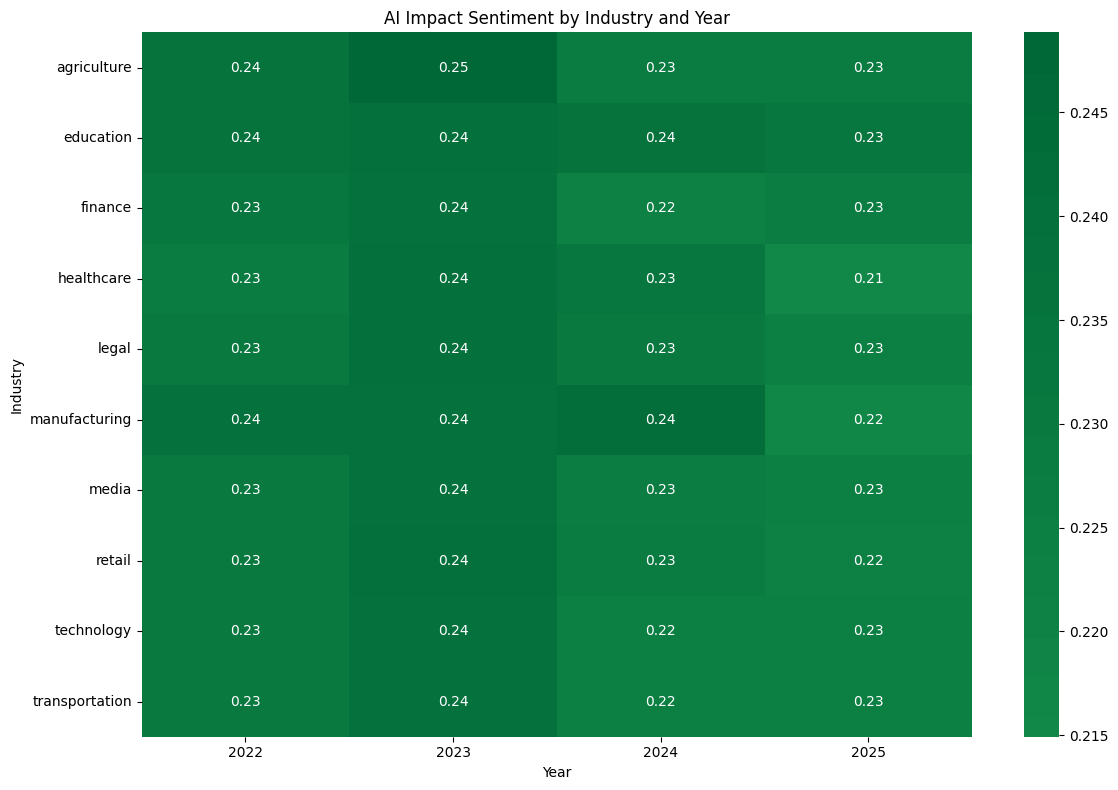

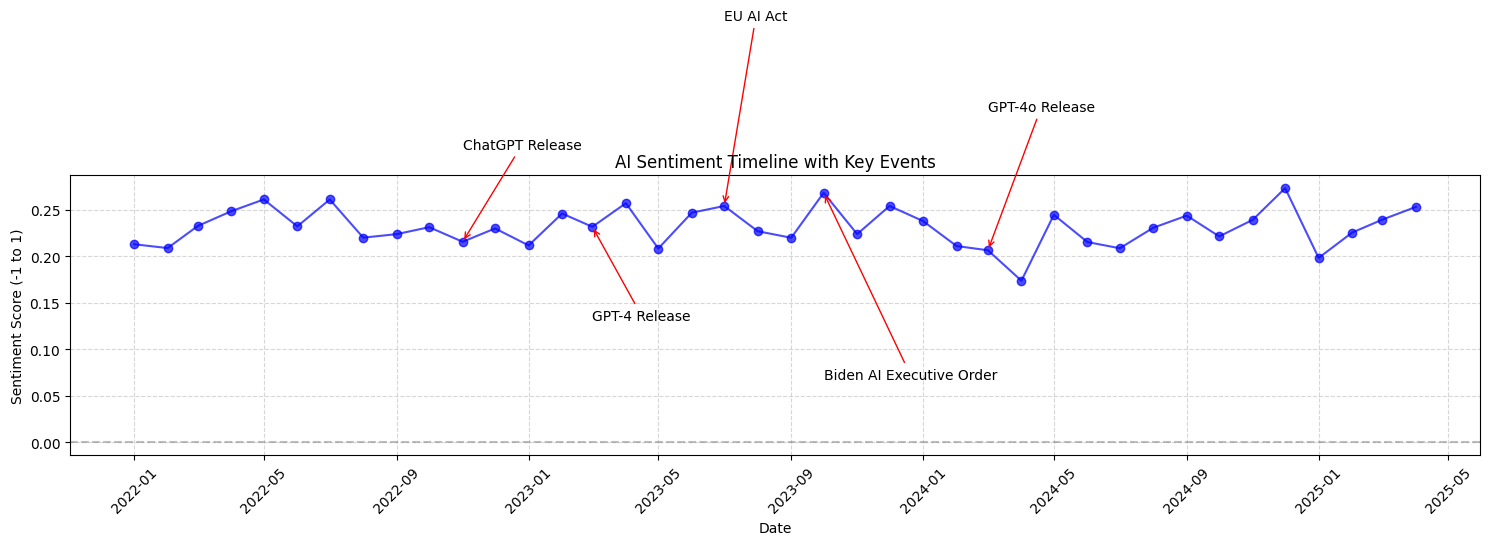

<Figure size 1400x700 with 0 Axes>

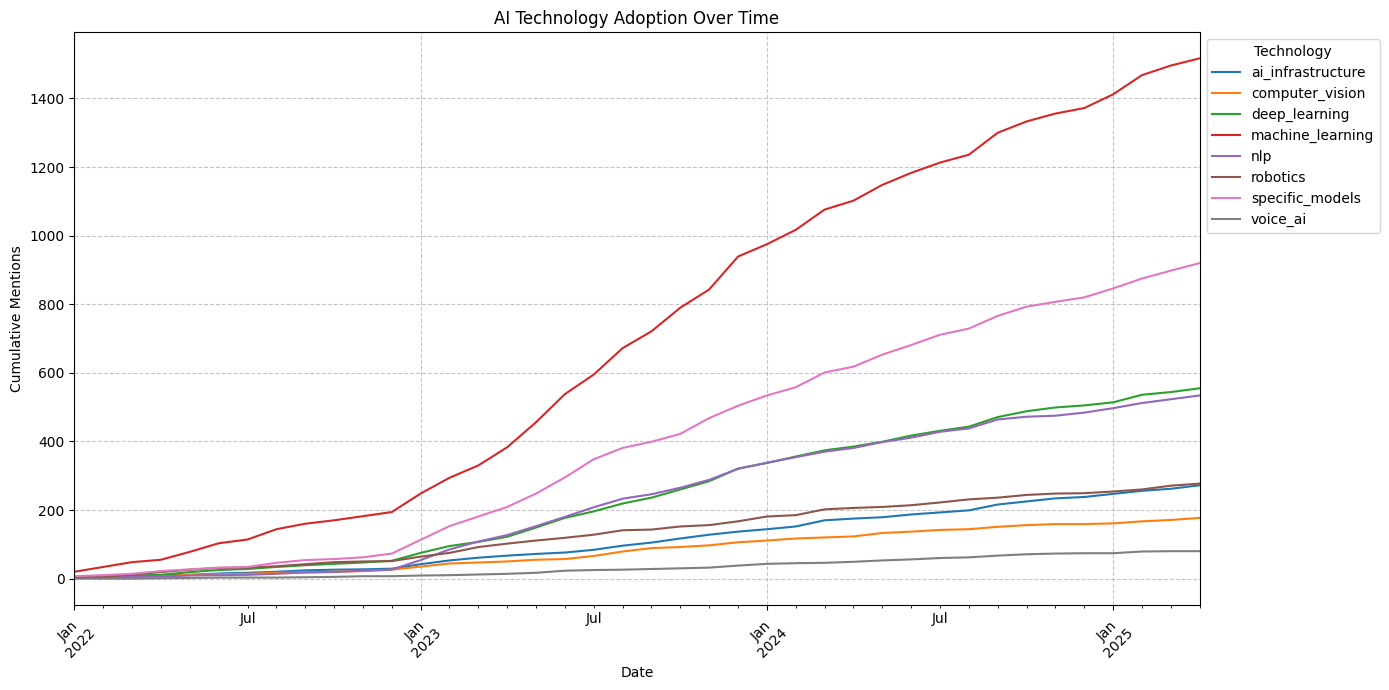

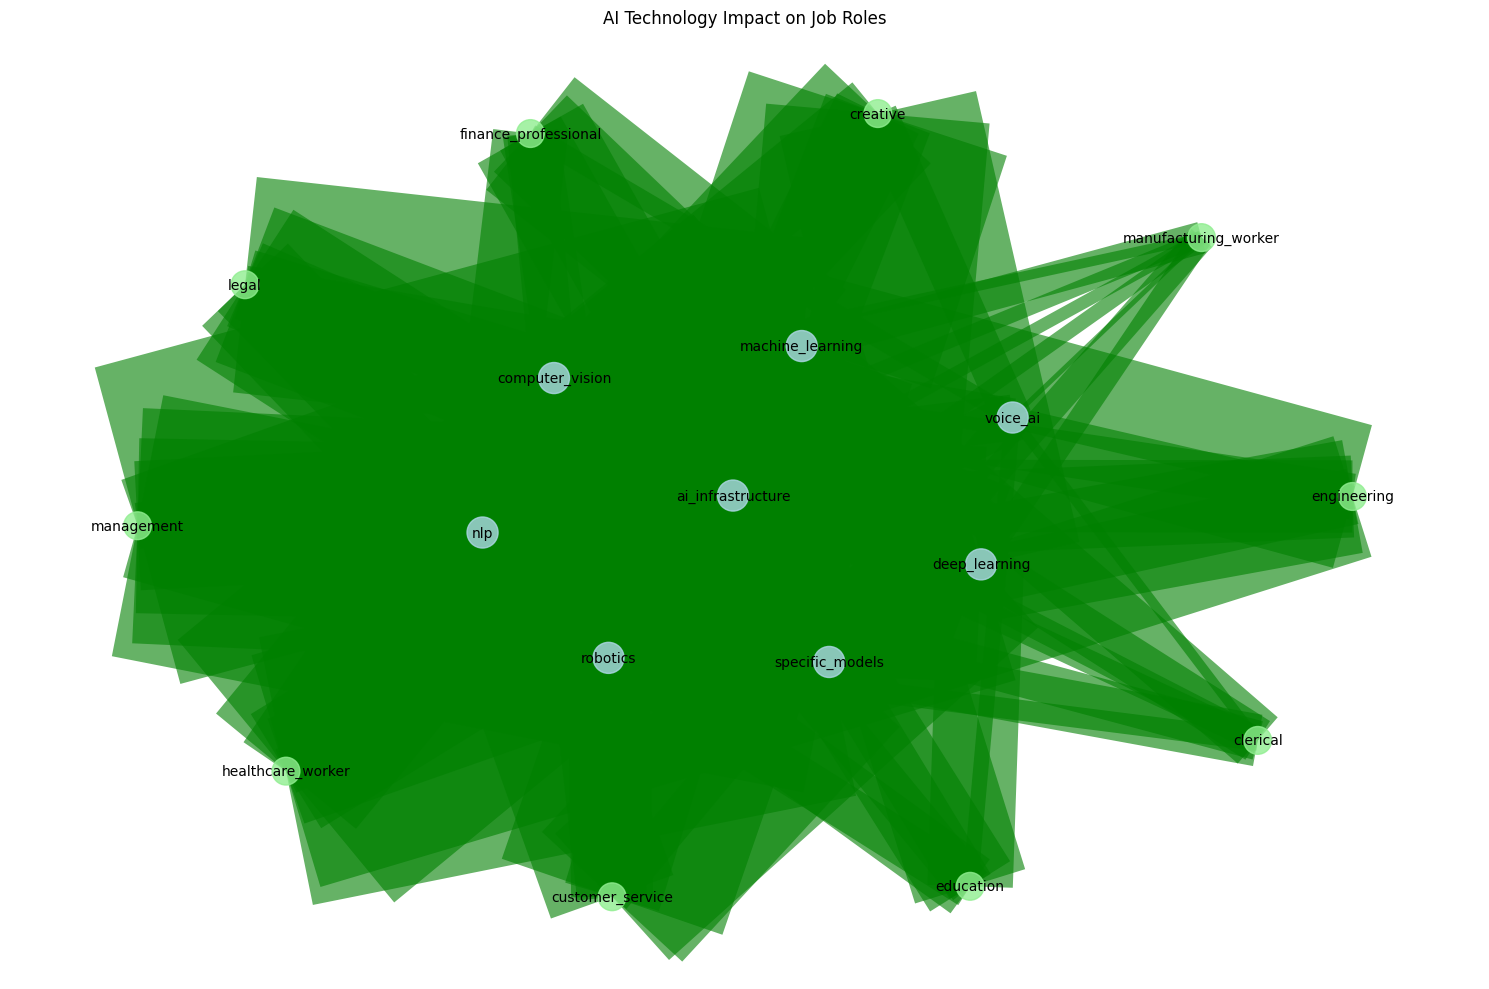

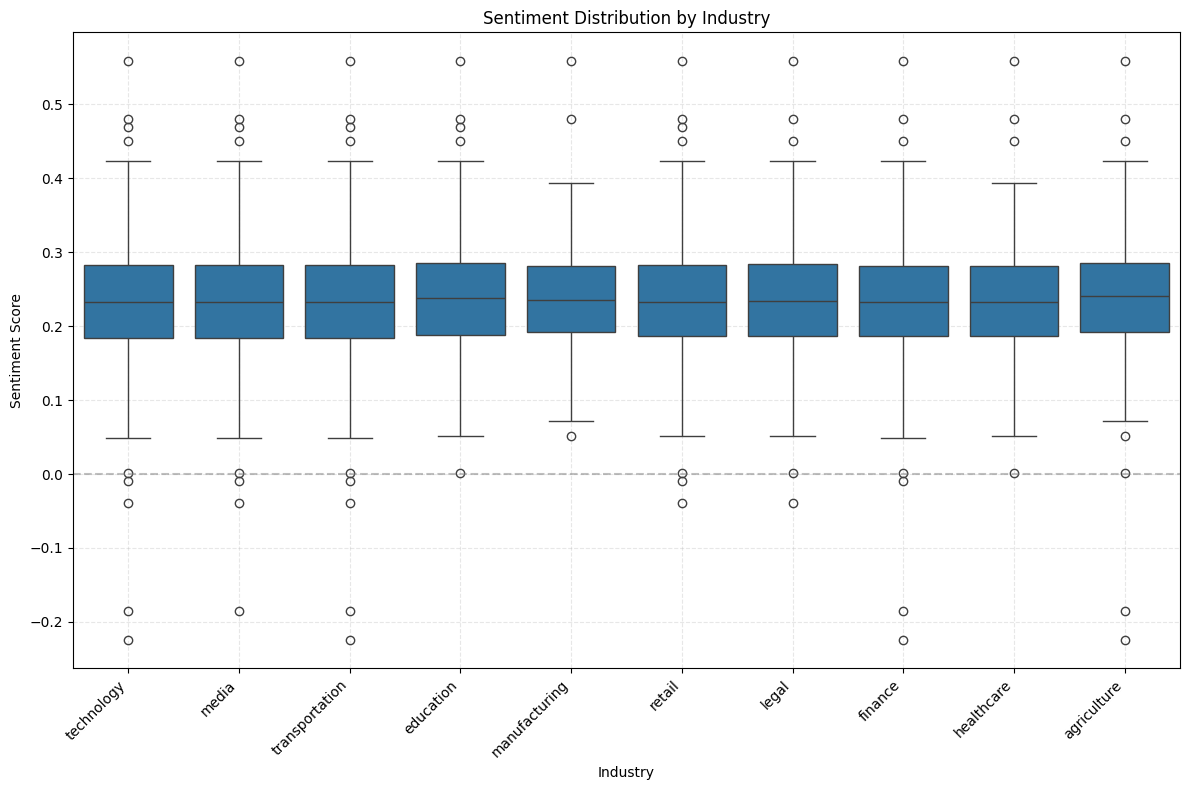

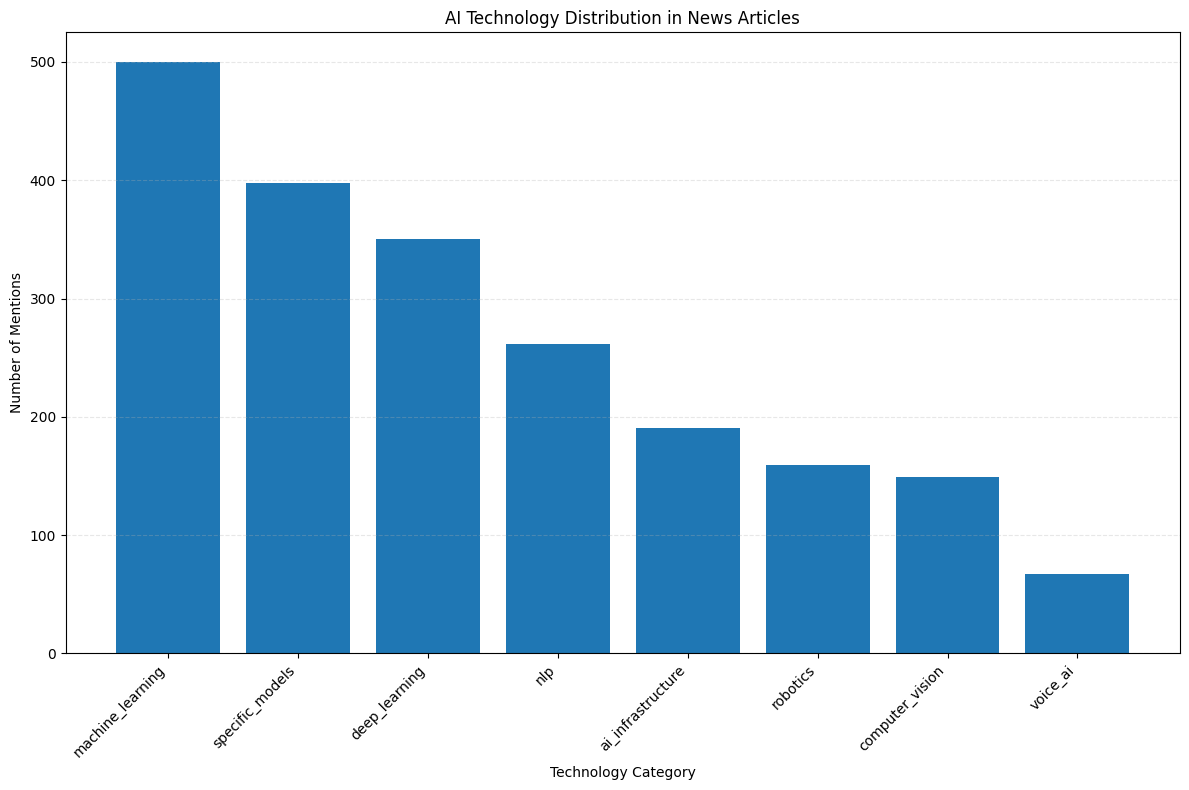

In [14]:
def main():
    """Main function to run the analysis"""
    data_path = 'https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet'
    cache_dir = 'cache'

    # Initialize analyzer
    analyzer = AINewsAnalyzer(data_path, cache_dir)

    # Running the pipeline with a sample size
    sample_size = 20000
    figures = analyzer.run_pipeline(sample_size=sample_size)

    # Save visualizations
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for name, fig in figures.items():
        fig.savefig(f"{output_dir}/{name}.png", dpi=300, bbox_inches='tight')

    print(f"Saved {len(figures)} visualizations to {output_dir}/")

    return analyzer

if __name__ == "__main__":
    analyzer = main()

In [15]:
def create_job_impact_visualization(job_impact_data):
    """
    Create a visualization comparing jobs enhanced vs replaced by AI
    """
    # Convert to DataFrame if it's a dictionary
    if isinstance(job_impact_data, dict):
        df = pd.DataFrame(job_impact_data)
    else:
        df = job_impact_data.copy()

    # Sort by sentiment score within each impact type
    df = df.sort_values(by=['impact_type', 'sentiment_score'])

    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot horizontal bars for Enhanced jobs (positive sentiment is to the right)
    enhanced_df = df[df['impact_type'] == 'Enhanced']
    replaced_df = df[df['impact_type'] == 'Replaced']

    # Create the plot
    bars_enhanced = ax.barh(y=enhanced_df['job_category'],
                          width=enhanced_df['sentiment_score'],
                          height=0.7,
                          color=palette[3],
                          alpha=0.8,
                          label='Enhanced by AI')

    bars_replaced = ax.barh(y=replaced_df['job_category'],
                          width=replaced_df['sentiment_score'],
                          height=0.7,
                          color=palette[7],
                          alpha=0.8,
                          label='At Risk from AI')

    # Add job category labels to each bar
    for i, bar in enumerate(bars_enhanced):
        width = bar.get_width()
        label_x_pos = width + 0.01
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2,
                f"{enhanced_df['mention_count'].iloc[i]} mentions",
                va='center', fontsize=10)

    for i, bar in enumerate(bars_replaced):
        width = bar.get_width()
        label_x_pos = width + 0.01
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2,
                f"{replaced_df['mention_count'].iloc[i]} mentions",
                va='center', fontsize=10)

    # Set plot aesthetics
    ax.set_xlabel('Impact Score (Sentiment × Mention Frequency)', fontsize=12)
    ax.set_title('Jobs Enhanced vs. At Risk from AI Technologies', fontsize=16, pad=20)
    ax.legend(loc='upper right', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    fig.tight_layout()

    # Save the figure
    plt.savefig('ai_job_impact_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    return fig

In [16]:
def create_success_failure_quadrant(app_data):
    """
    Create a quadrant chart showing AI application success vs complexity
    """
    # Convert to DataFrame if it's a dictionary
    if isinstance(app_data, dict):
        df = pd.DataFrame(app_data)
    else:
        df = app_data.copy()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create scatter plot
    scatter = ax.scatter(x=df['implementation_complexity'],
                       y=df['success_score'],
                       s=df['mention_count'],
                       c=df['success_score'],
                       cmap=success_colors,
                       alpha=0.7,
                       edgecolors='black')

    # Add labels for each point
    for i, txt in enumerate(df['application']):
        ax.annotate(txt,
                  (df['implementation_complexity'].iloc[i], df['success_score'].iloc[i]),
                  fontsize=9,
                  ha='center',
                  va='center',
                  xytext=(0, 10),
                  textcoords='offset points')

    # Add quadrant dividers
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    # Add quadrant labels
    ax.text(0.25, 0.9, 'EASY WINS', fontsize=12, ha='center', va='center', alpha=0.7)
    ax.text(0.75, 0.9, 'STRATEGIC INVESTMENTS', fontsize=12, ha='center', va='center', alpha=0.7)
    ax.text(0.25, 0.1, 'LOW PRIORITY', fontsize=12, ha='center', va='center', alpha=0.7)
    ax.text(0.75, 0.1, 'CHALLENGING BUT POSSIBLE', fontsize=12, ha='center', va='center', alpha=0.7)

    # Add a colorbar legend
    cbar = plt.colorbar(scatter)
    cbar.set_label('Success Score', fontsize=12)

    # Add a legend for the size of points
    sizes = df['mention_count']
    size_legend_sizes = [min(sizes), max(sizes)/2, max(sizes)]
    size_legend_labels = [f'{int(size)} mentions' for size in size_legend_sizes]

    # Create a legend for sizes
    for size, label in zip(size_legend_sizes, size_legend_labels):
        ax.scatter([], [], c='gray', alpha=0.7, s=size, edgecolors='black', label=label)
    ax.legend(loc='upper left', title='Mention Frequency')

    # Set plot aesthetics
    ax.set_xlabel('Implementation Complexity', fontsize=12)
    ax.set_ylabel('Success Score', fontsize=12)
    ax.set_title('AI Applications: Success vs. Implementation Complexity', fontsize=16, pad=20)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Save the figure
    plt.savefig('ai_application_quadrant.png', dpi=300, bbox_inches='tight')
    plt.close()

    return fig

In [17]:
def create_investment_network(investment_data):
    """
    Create a network visualization of AI investments
    """
    # Convert to DataFrame if it's a dictionary
    if isinstance(investment_data, dict):
        df = pd.DataFrame(investment_data)
    else:
        df = investment_data.copy()

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges with weights
    for _, row in df.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['amount'])
        # Add node attributes
        G.nodes[row['source']]['industry'] = row['source_industry'] if 'source_industry' in row else 'Unknown'
        G.nodes[row['target']]['industry'] = row['target_industry'] if 'target_industry' in row else 'Unknown'

    # Calculate node sizes based on degree centrality
    centrality = nx.degree_centrality(G)
    node_sizes = [centrality[node] * 5000 + 100 for node in G.nodes()]

    # Get unique industries for color mapping
    industries = set()
    for node in G.nodes():
        if 'industry' in G.nodes[node]:
            industries.add(G.nodes[node]['industry'])

    # Create color map
    industry_colors = {}
    for i, industry in enumerate(industries):
        industry_colors[industry] = palette[i % len(palette)]

    node_colors = [industry_colors.get(G.nodes[node].get('industry', 'Unknown'), 'gray') for node in G.nodes()]

    # Calculate edge widths based on weights
    edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

    # Set up the figure
    plt.figure(figsize=(14, 12))

    # Position nodes using a force-directed layout
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray',
                         arrowstyle='-|>', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    # Create a legend for industries
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 label=industry, markerfacecolor=color, markersize=10)
                     for industry, color in industry_colors.items()]
    plt.legend(handles=legend_elements, title="Industry Sectors", loc="upper left")

    # Set plot aesthetics
    plt.title('AI Investment Network: Companies and Relationships', fontsize=16)
    plt.axis('off')

    # Save the figure
    plt.savefig('ai_investment_network.png', dpi=300, bbox_inches='tight')
    plt.close()

    return plt.gcf()

In [18]:
def create_transformation_roadmap(roadmap_data):
    """
    Create a visualization showing the AI transformation roadmap by industry
    """
    # Convert to DataFrame if it's a dictionary
    if isinstance(roadmap_data, dict):
        df = pd.DataFrame(roadmap_data)
    else:
        df = roadmap_data.copy()

    # Sort by current adoption
    df = df.sort_values('current_adoption', ascending=False)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Set positions for the bars
    industries = df['industry']
    x = np.arange(len(industries))
    width = 0.25

    # Create the bars
    current = ax.barh(x - width, df['current_adoption'], width, label='Current (2025)',
                     color=palette[1], alpha=0.8)

    proj_2026 = ax.barh(x, df['projected_adoption_2026'], width, label='Projected (2026)',
                       color=palette[4], alpha=0.8)

    proj_2028 = ax.barh(x + width, df['projected_adoption_2028'], width, label='Projected (2028)',
                       color=palette[7], alpha=0.8)

    # Add annotations for challenges
    for i, challenge in enumerate(df['critical_challenge']):
        ax.text(0.05, i, f"Challenge: {challenge}", va='center', fontsize=9,
              bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

    # Set plot aesthetics
    ax.set_yticks(x)
    ax.set_yticklabels(industries)
    ax.set_xlabel('AI Adoption Level (0-1 scale)', fontsize=12)
    ax.set_title('AI Transformation Roadmap by Industry', fontsize=16, pad=20)
    ax.legend(loc='upper right', fontsize=10)

    # Add vertical lines for adoption milestones
    ax.axvline(x=0.25, color='gray', linestyle='--', alpha=0.3, label='Early Adoption')
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, label='Mainstream Adoption')
    ax.axvline(x=0.75, color='gray', linestyle='--', alpha=0.3, label='Advanced Adoption')

    ax.text(0.25, -0.5, 'Early', ha='center', alpha=0.7)
    ax.text(0.5, -0.5, 'Mainstream', ha='center', alpha=0.7)
    ax.text(0.75, -0.5, 'Advanced', ha='center', alpha=0.7)

    # Set axis limits
    ax.set_xlim(0, 1)

    # Save the figure
    plt.tight_layout()
    plt.savefig('ai_transformation_roadmap.png', dpi=300, bbox_inches='tight')
    plt.close()

    return fig